# Timeline Visualization

Notebook to visualize how accesses move across data during an iteration.

Idea: make a 2d plot where x is the time of access, y is the coordinate accessed.

In [2]:
# import the miniapp code and numpy for data management
import main
import numpy as np

In [3]:
# Subclass an object of the miniapp to trace some of its functions
class TracedHamiltonian(main.Hamiltonian):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # figure out the size of the integrals space
        maxs = [0,0,0,0]
        for t in self.d_two_e_integral:
            for i,x in enumerate(t):
                maxs[i] = max(maxs[i], x)
        maxs = [ i+1 for i in maxs]
        # save the timeline as a list of accesses
        self.timeline = np.zeros(tuple(maxs))
        self.time = 0
        self.block = 1
        
    def reset_trace(self):
        self.timeline = np.zeros(self.timeline.shape)
        self.time = 0
        
    def H_two_e(self, i, j, k, l):
        timeblock = int(self.time / self.block)
        self.timeline[i,j,k,l] = timeblock
        self.time += 1
        return super().H_two_e(i,j,k,l)
    
    def view2d(self):
        d1 = self.timeline.shape[0]
        # return a 2d view of it
        d = d1 * d1
        return self.timeline.reshape((d,d))

## Trace over a single inner step

Here we just run a simple example, with a traced Hamiltonian and a single pass on the inner loop.

In [4]:
fci_path = 'f2_631g.FCIDUMP'
wf_path = 'f2_631g.30det.wf'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
lewis = TracedHamiltonian(d_one_e_integral, d_two_e_integral, E0)

main.Powerplant(lewis, psi_det).E(psi_coef)

-198.73878098910563

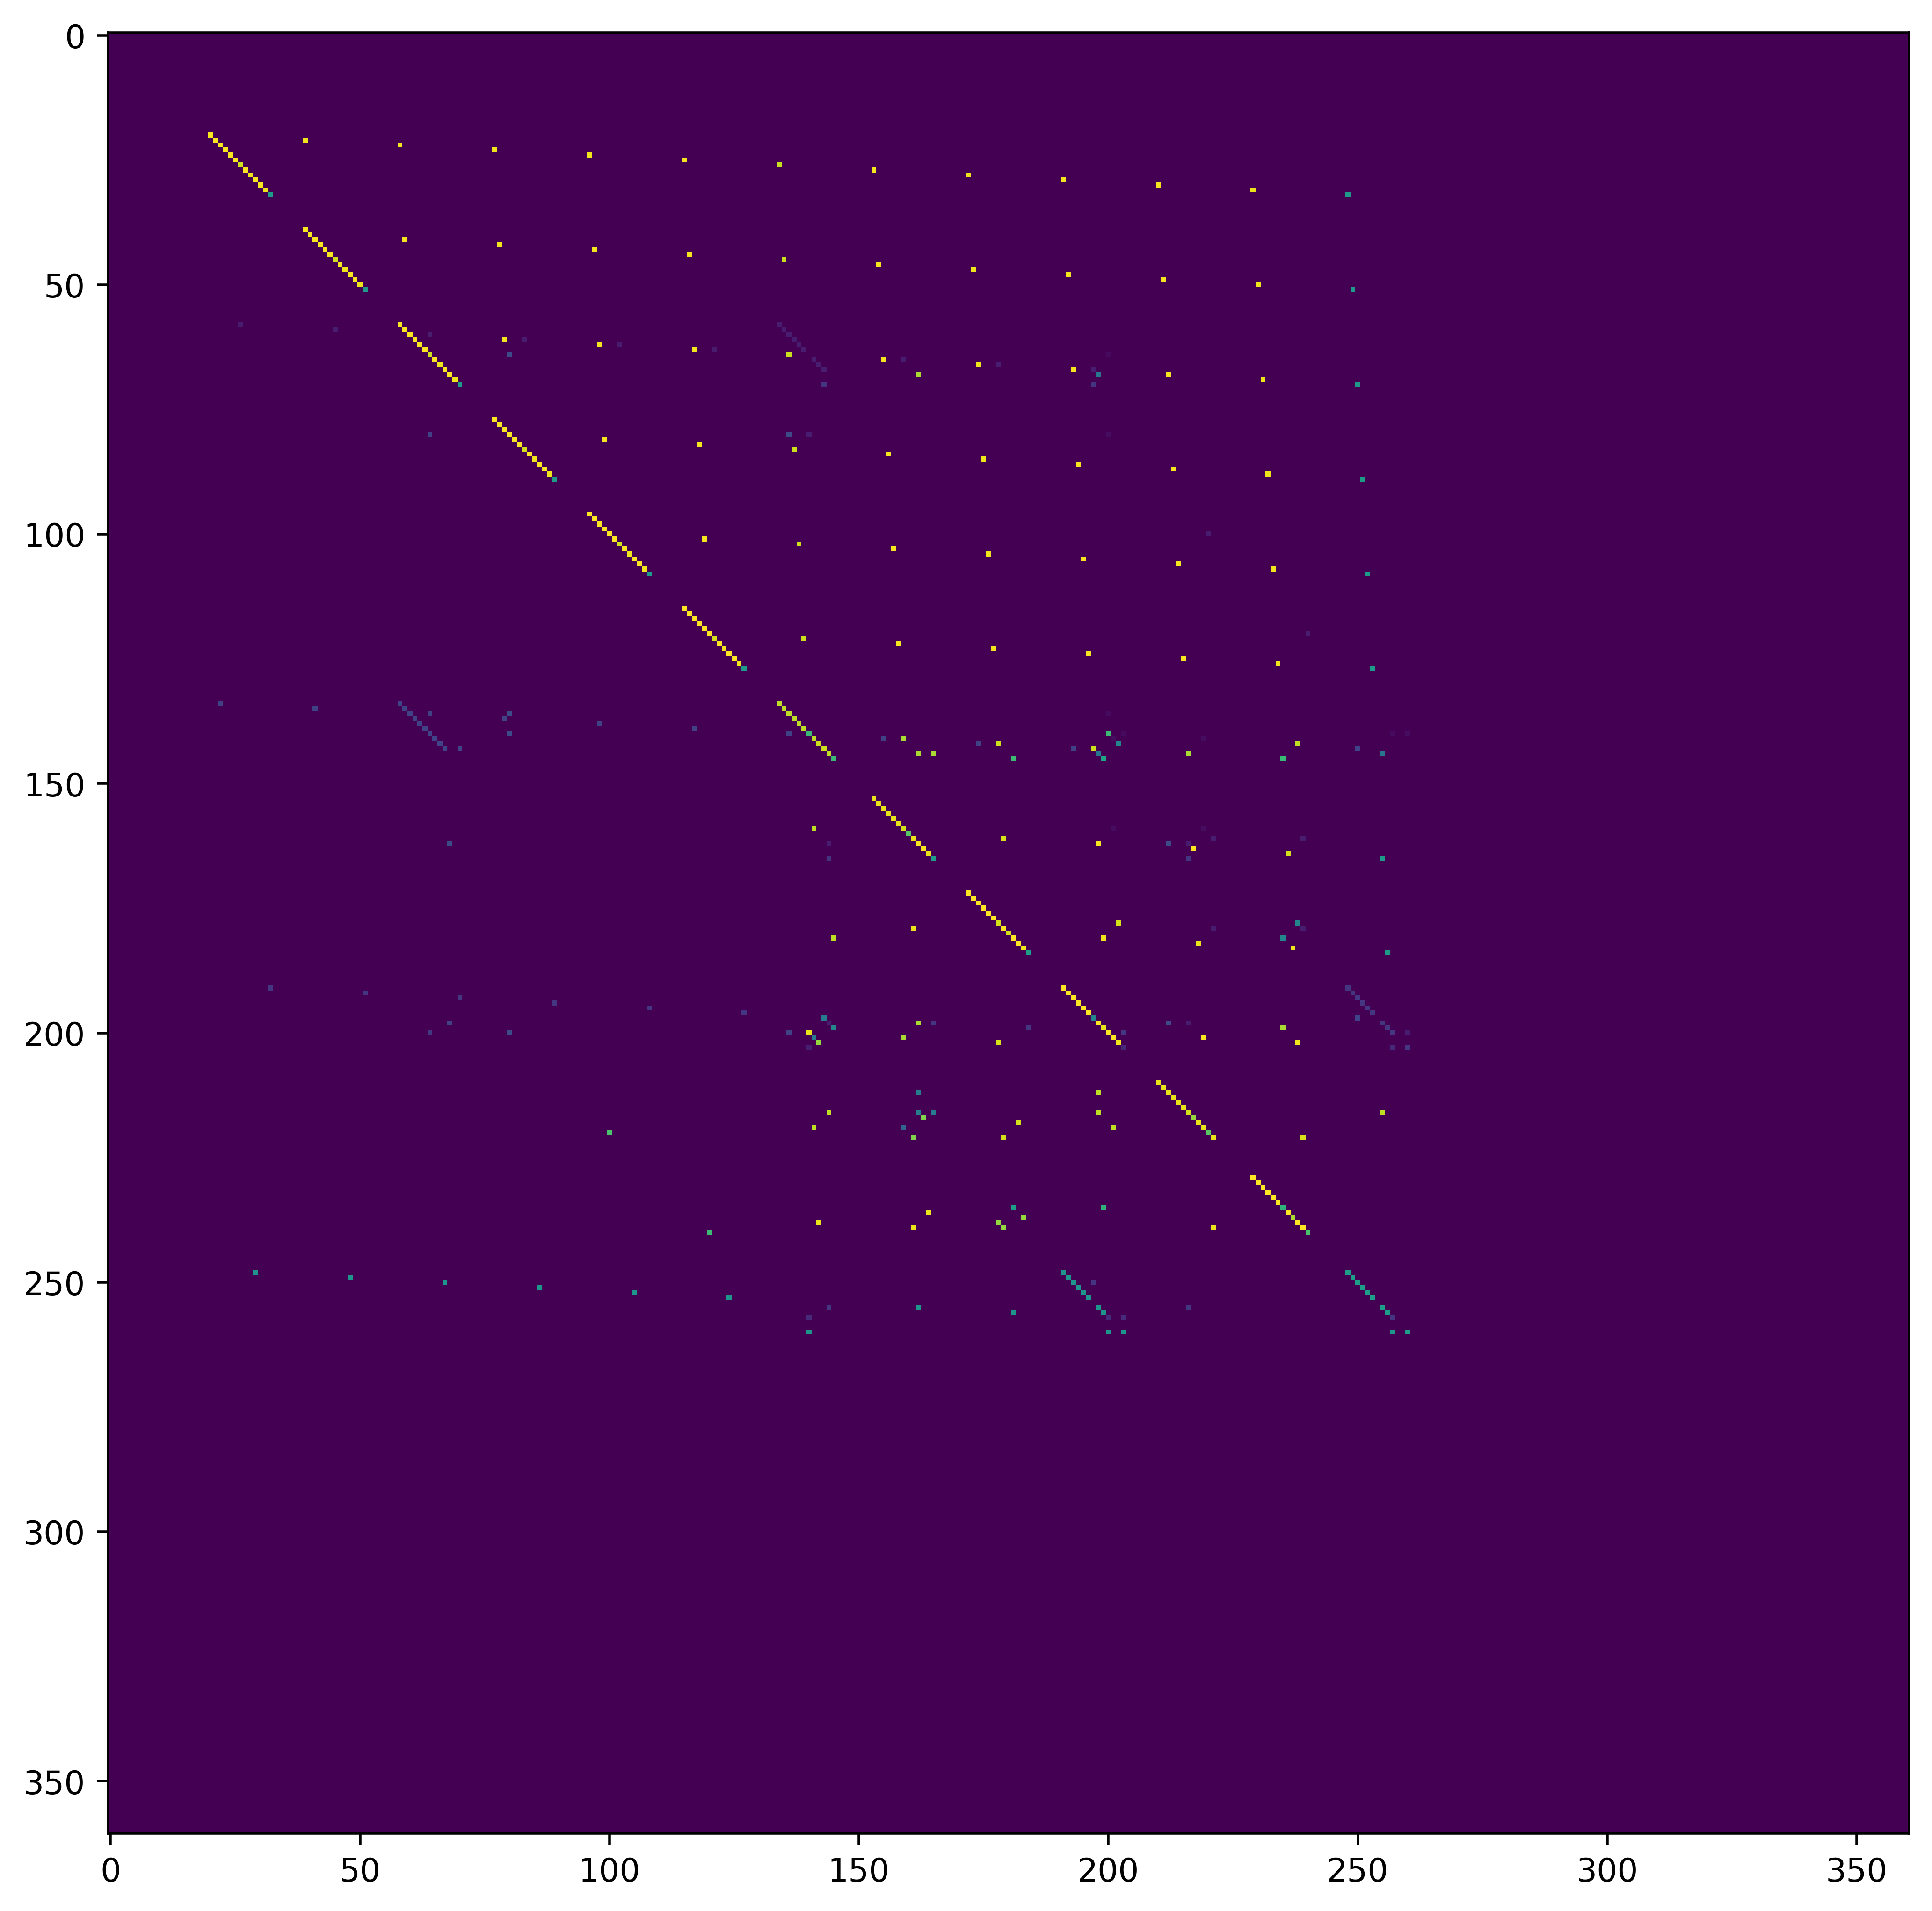

In [5]:
# Retrieve a 2d view and plot it
import matplotlib.pyplot as plt


view = lewis.view2d()
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 500
plt.imshow(view, cmap='viridis')
plt.show()

In [6]:
# Old style inner loop, with PT2 computation and manual threashold for determinant selection
# from main import selection_step
# maps = []
# n = 5
# lewis.reset_trace()
# for i in range(4):
#     _, psi_coef, psi_det = selection_step(lewis, N_ord, psi_coef, psi_det, n)
#     maps.append(np.copy(lewis.view2d()))
#     n = n*2

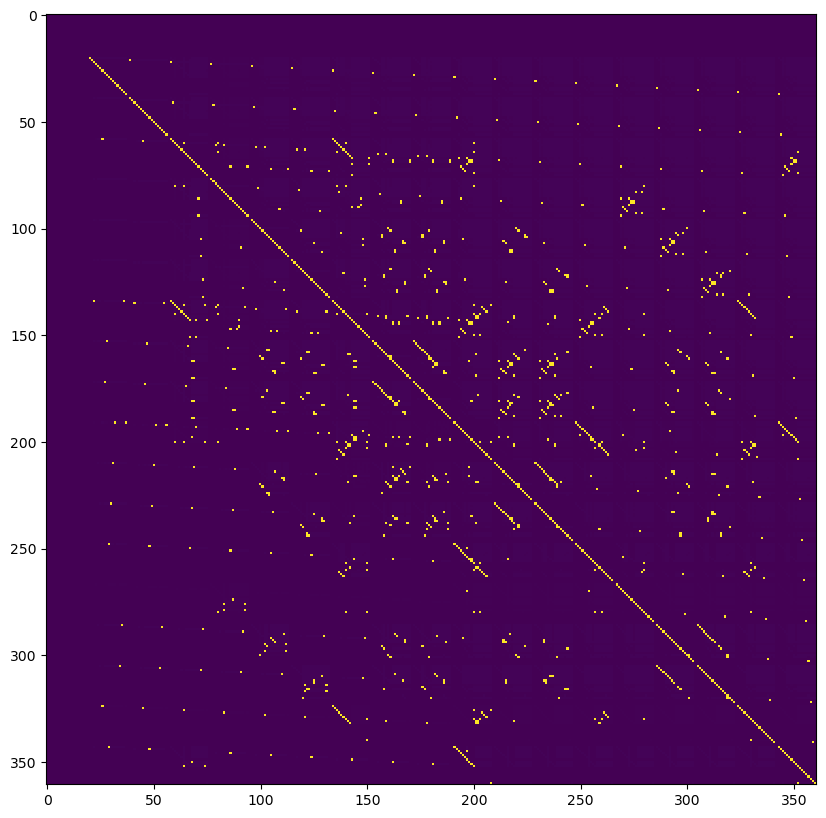

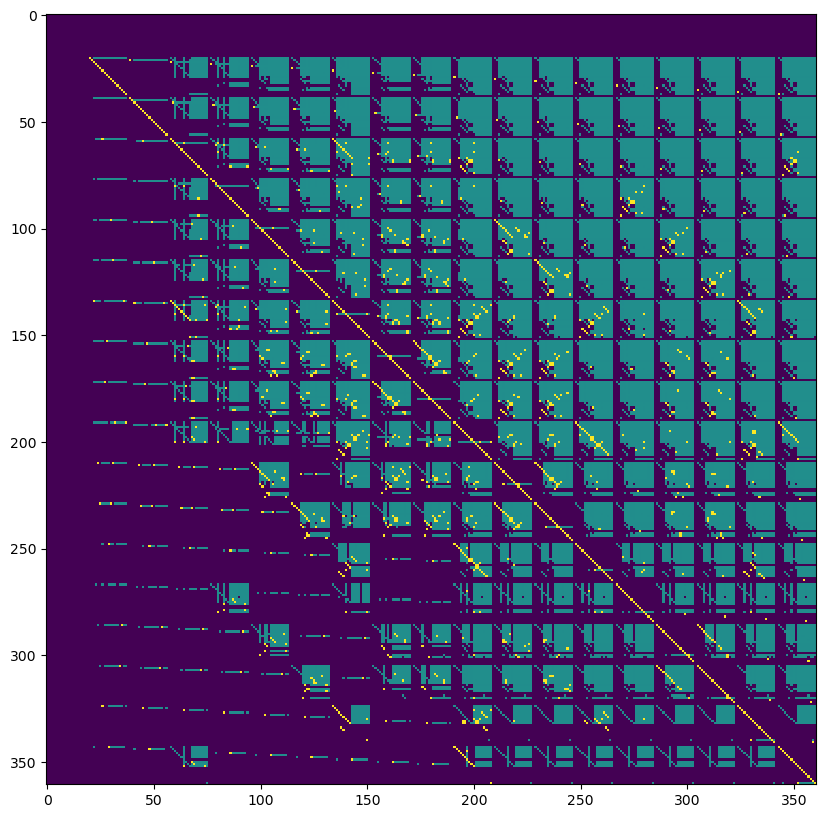

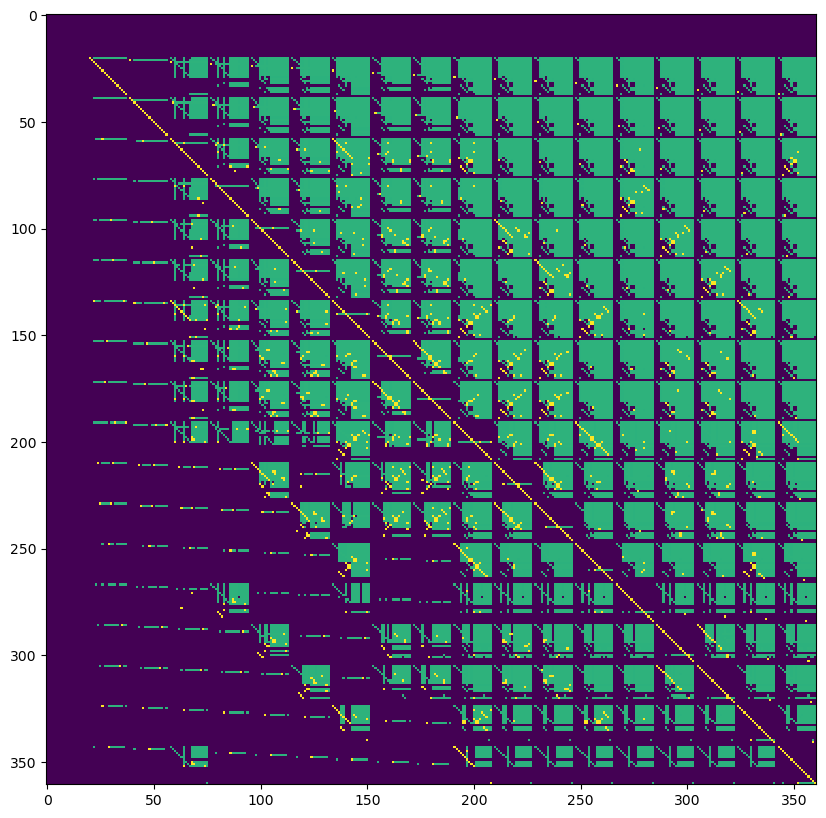

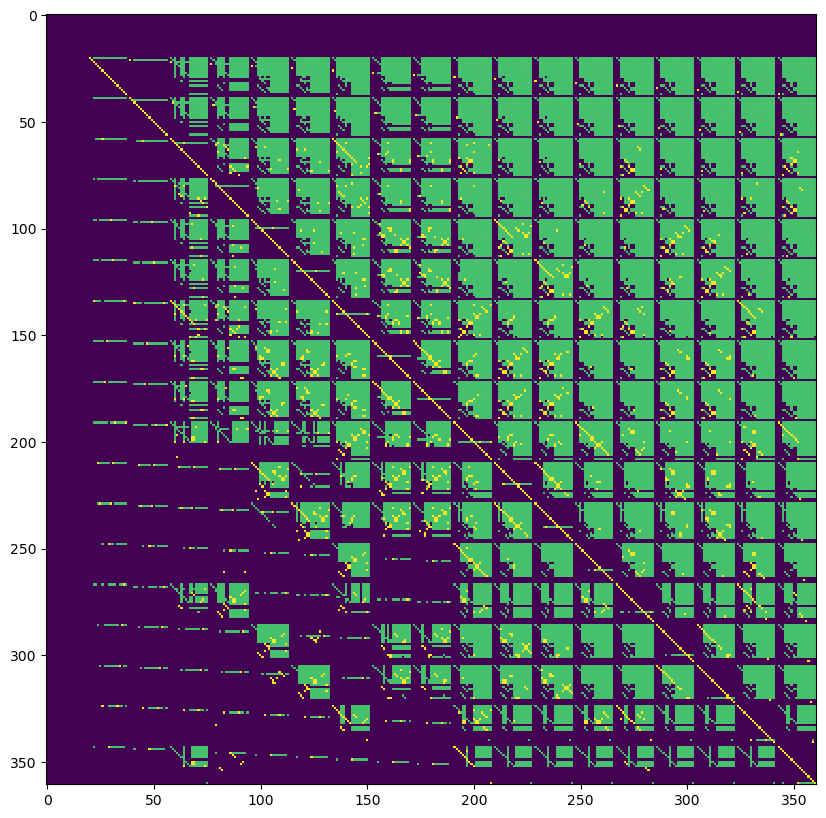

In [23]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100
for m in maps:
    plt.imshow(m, cmap='viridis')
    plt.show()

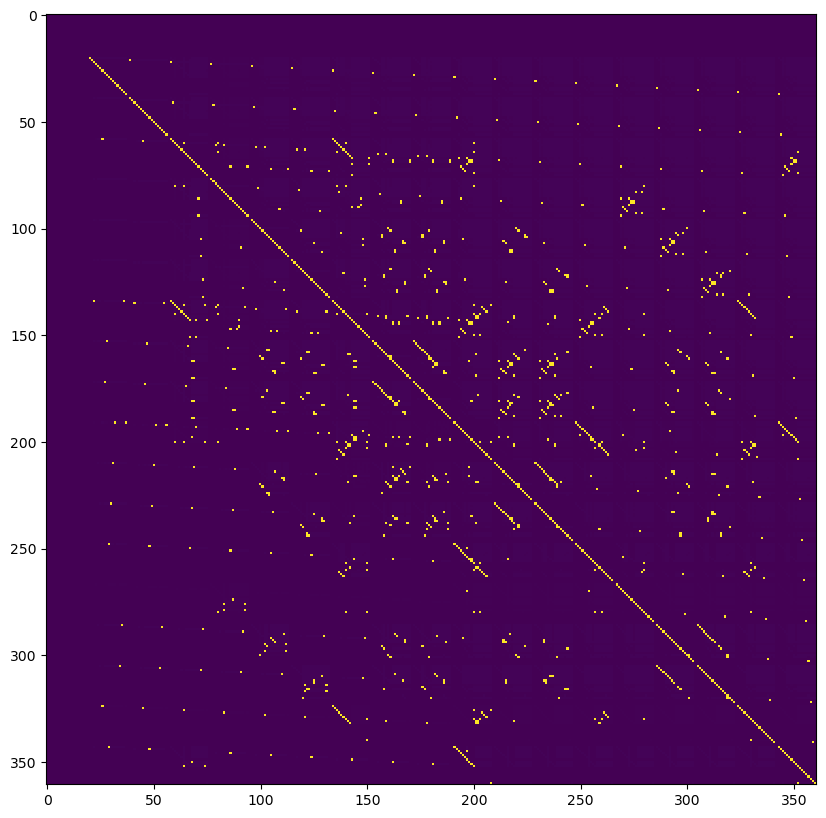

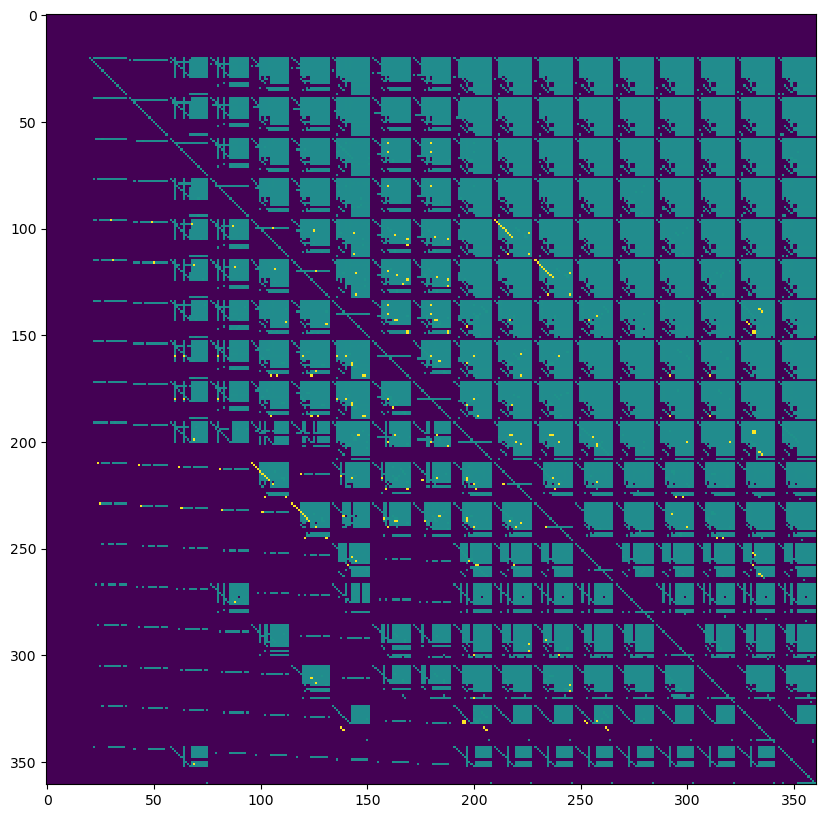

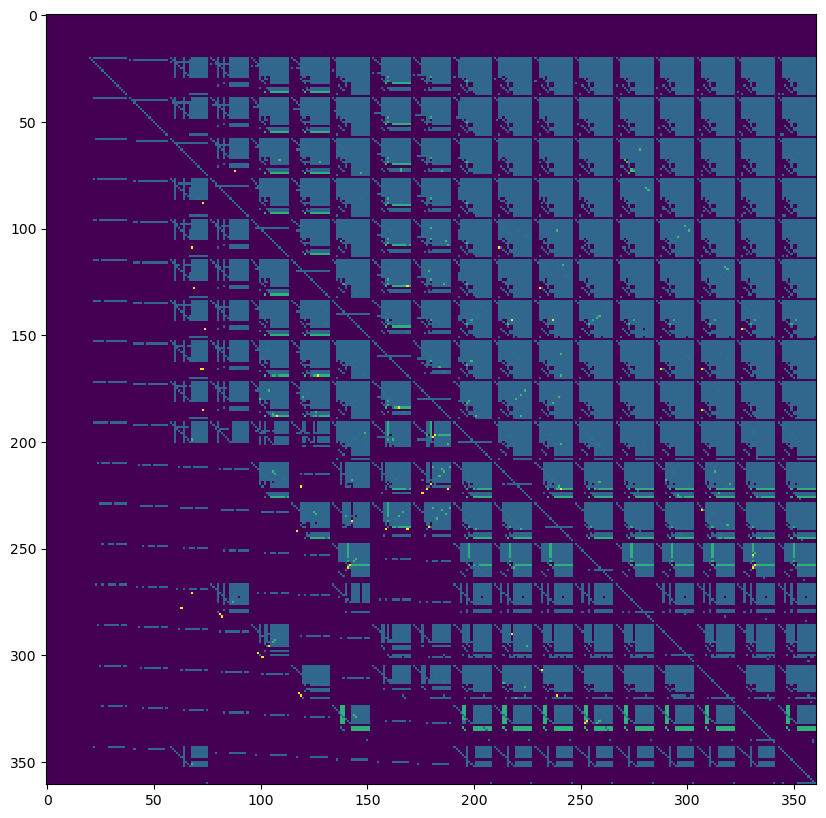

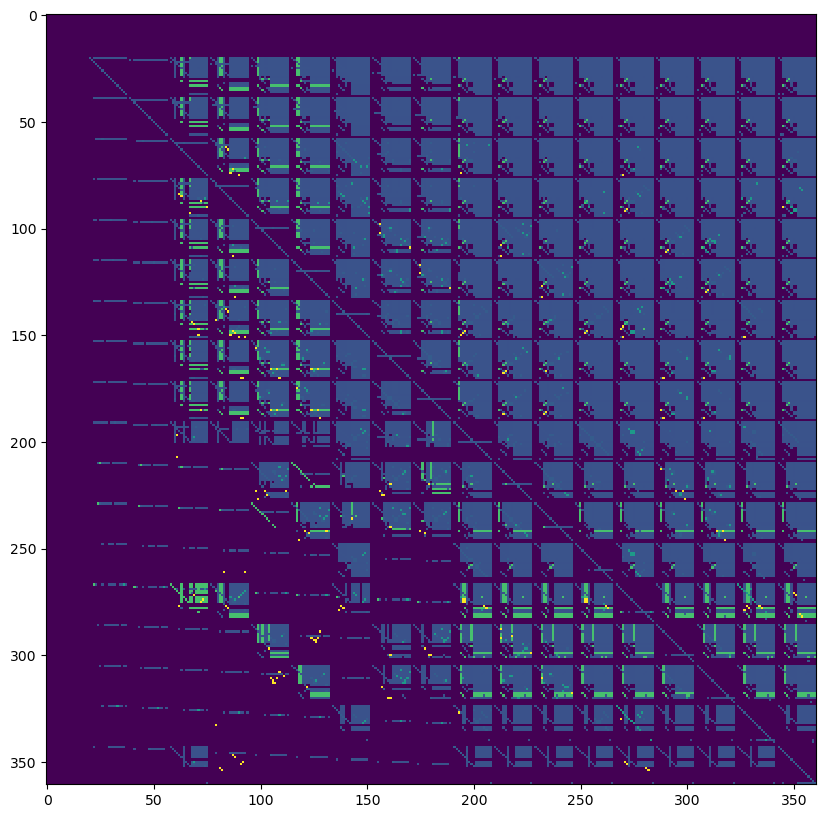

In [24]:
d = np.zeros(maps[0].shape)
for m in maps:
    v = m - d
    plt.imshow(v, cmap='viridis')
    plt.show()
    d = m

## Tracing across several inner loops

Note that we use checkpoints to avoid executing the PT2, that is too expensive in this case

In [12]:
# if you need profiling, this is a single step with Timings for the core code
import cProfile
i = 10
fci_path='c2_eq_hf_dz.fcidump*'
wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
lewis = TracedHamiltonian(d_one_e_integral, d_two_e_integral, E0)
cProfile.run("main.Powerplant(lewis, psi_det).E(psi_coef)")

         71401587 function calls in 35.975 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.015    0.015 <__array_function__ internals>:2(einsum)
  1032660    0.987    0.000    1.297    0.000 <ipython-input-3-d73318dd917a>:20(H_two_e)
        1    0.000    0.000   35.975   35.975 <string>:1(<module>)
        1    0.000    0.000    0.015    0.015 einsumfunc.py:1004(einsum)
        6    0.000    0.000    0.000    0.000 einsumfunc.py:995(_einsum_dispatcher)
    54600    0.013    0.000    0.013    0.000 main.py:307(H_one_e)
  1032660    0.310    0.000    0.310    0.000 main.py:313(H_two_e)
   545712    1.853    0.000    2.190    0.000 main.py:321(get_phase_idx_single_exc)
  5852912    0.338    0.000    0.338    0.000 main.py:331(<lambda>)
    82272    0.500    0.000    0.701    0.000 main.py:336(get_phase_idx_double_exc)
  1646472    0.102    0.000    0.102    0.000 main.py:351(<lambda>)
     316

In [13]:
maps = []
for i in range(1, 10):
    fci_path='c2_eq_hf_dz.fcidump*'
    wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
    N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
    psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
    lewis = TracedHamiltonian(d_one_e_integral, d_two_e_integral, E0)
    main.Powerplant(lewis, psi_det).E(psi_coef)
    maps.append(np.copy(lewis.view2d()))

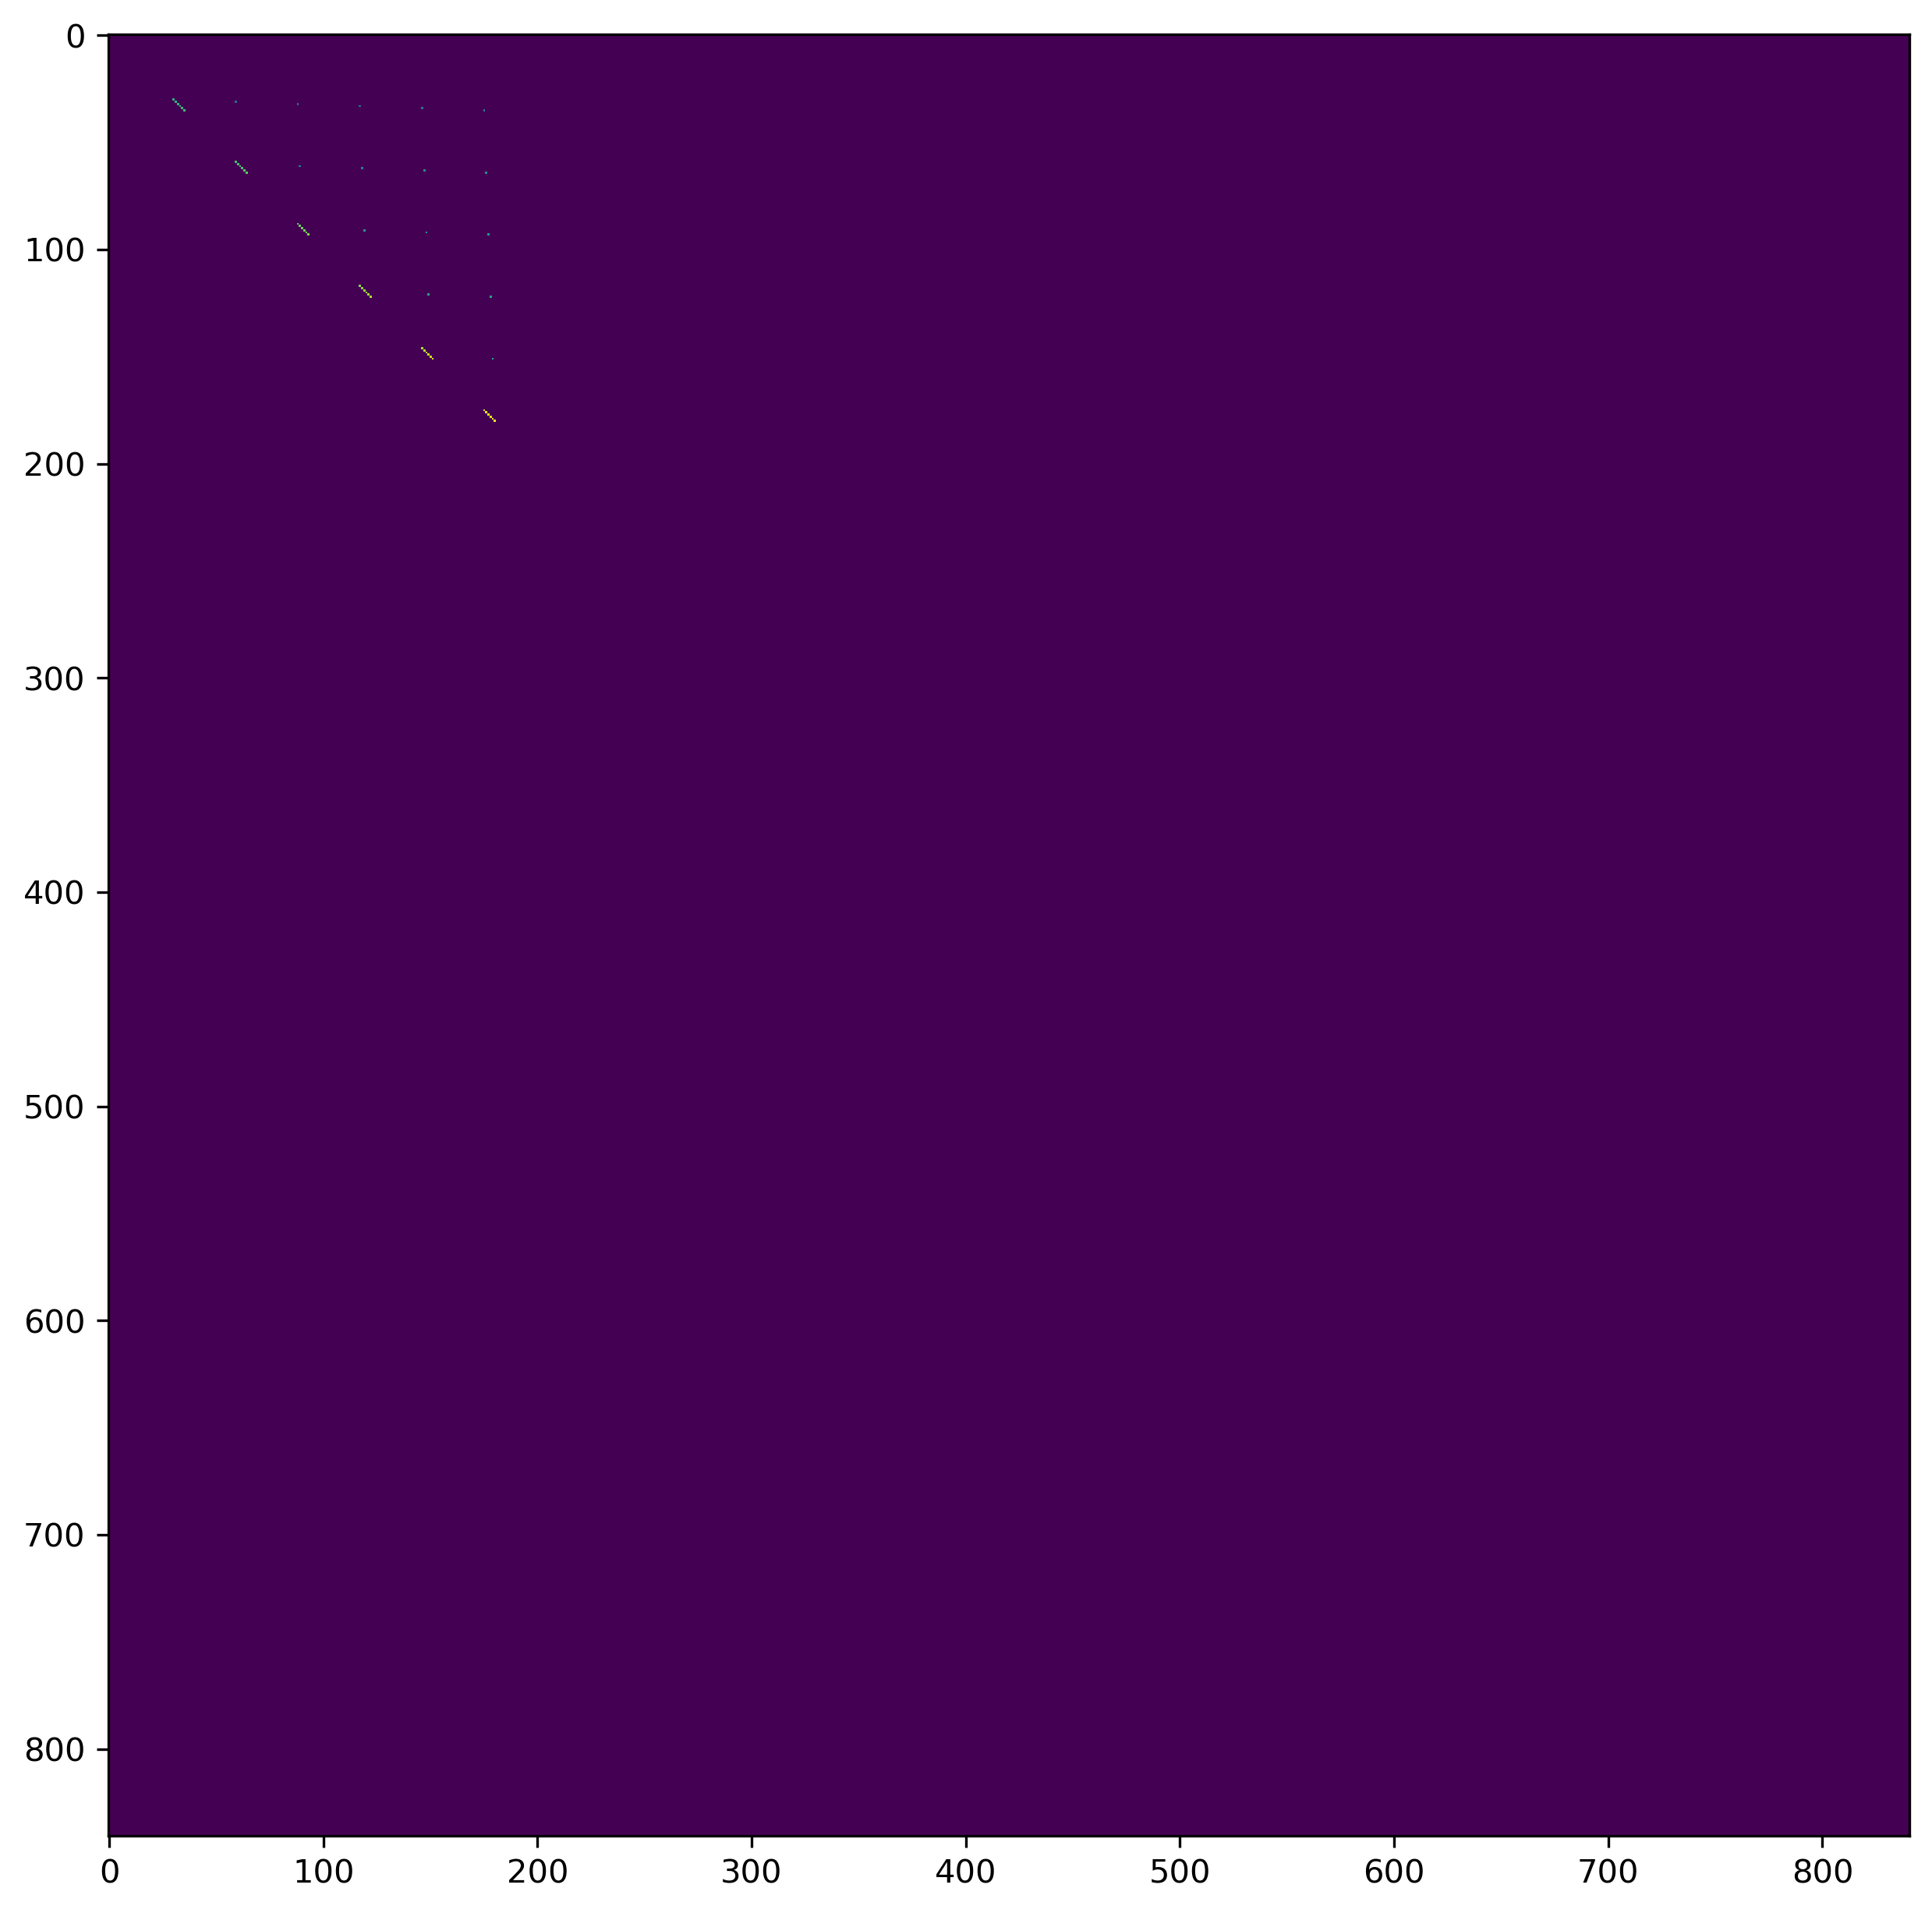

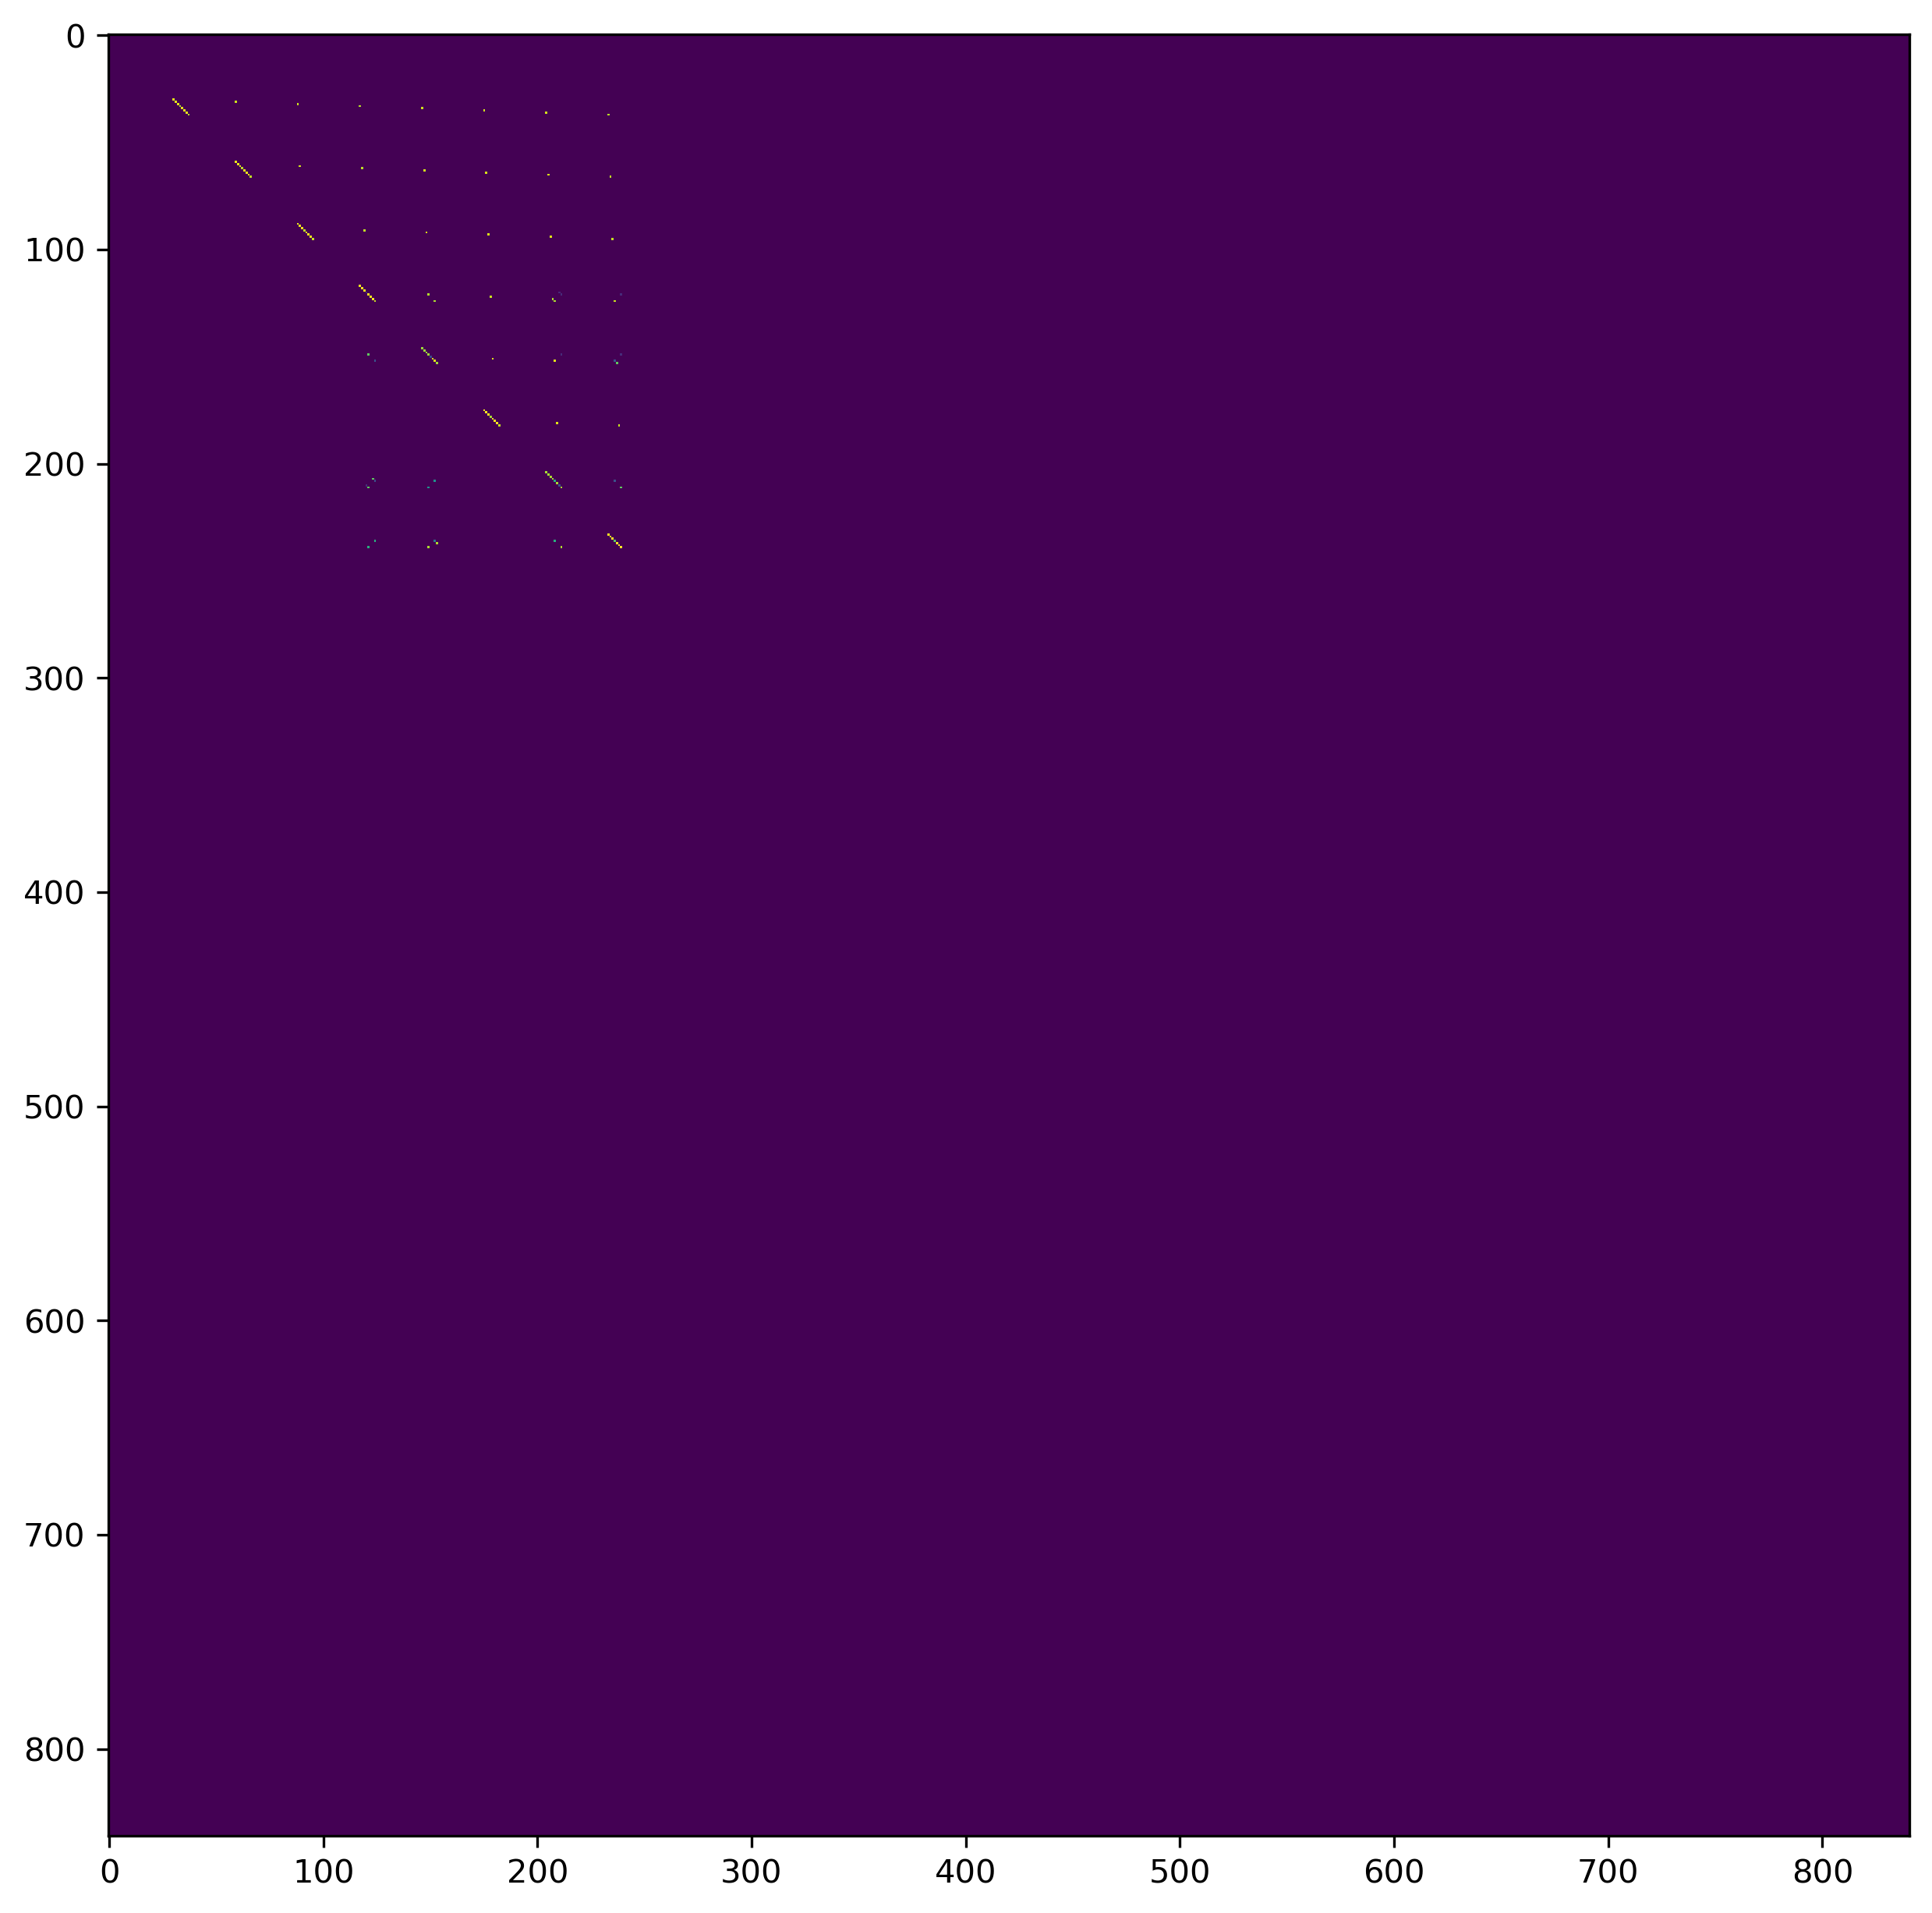

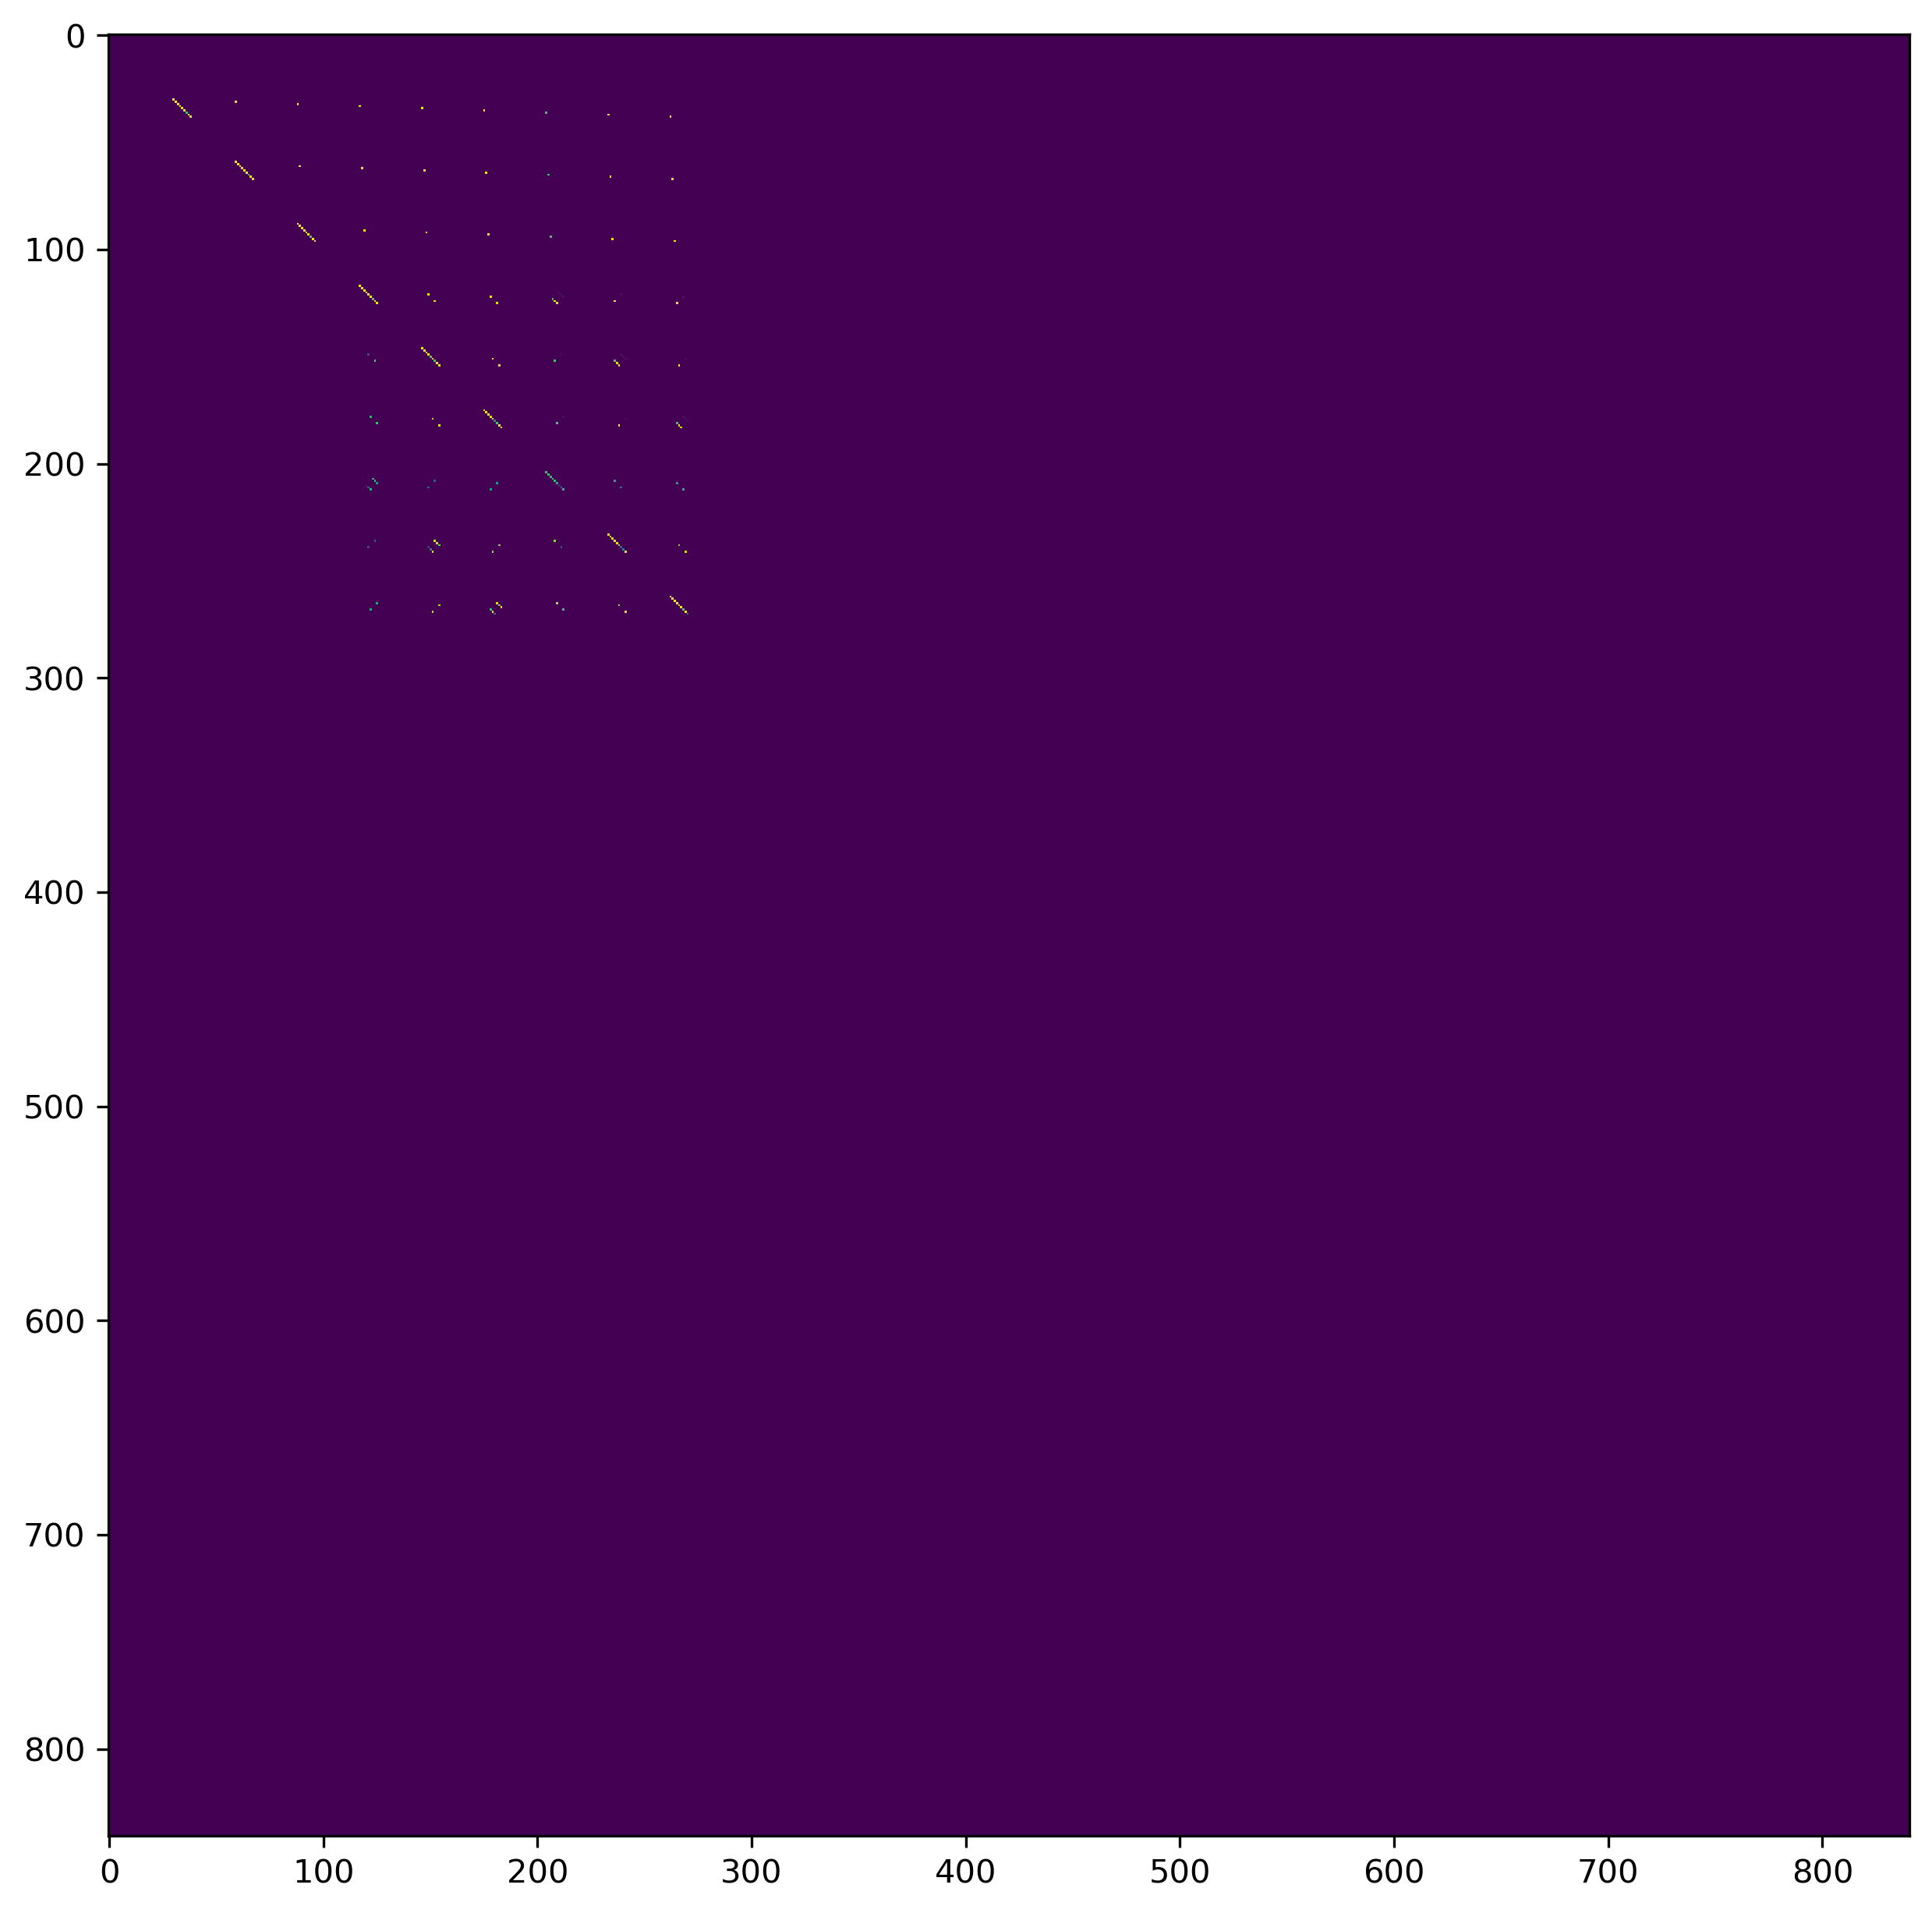

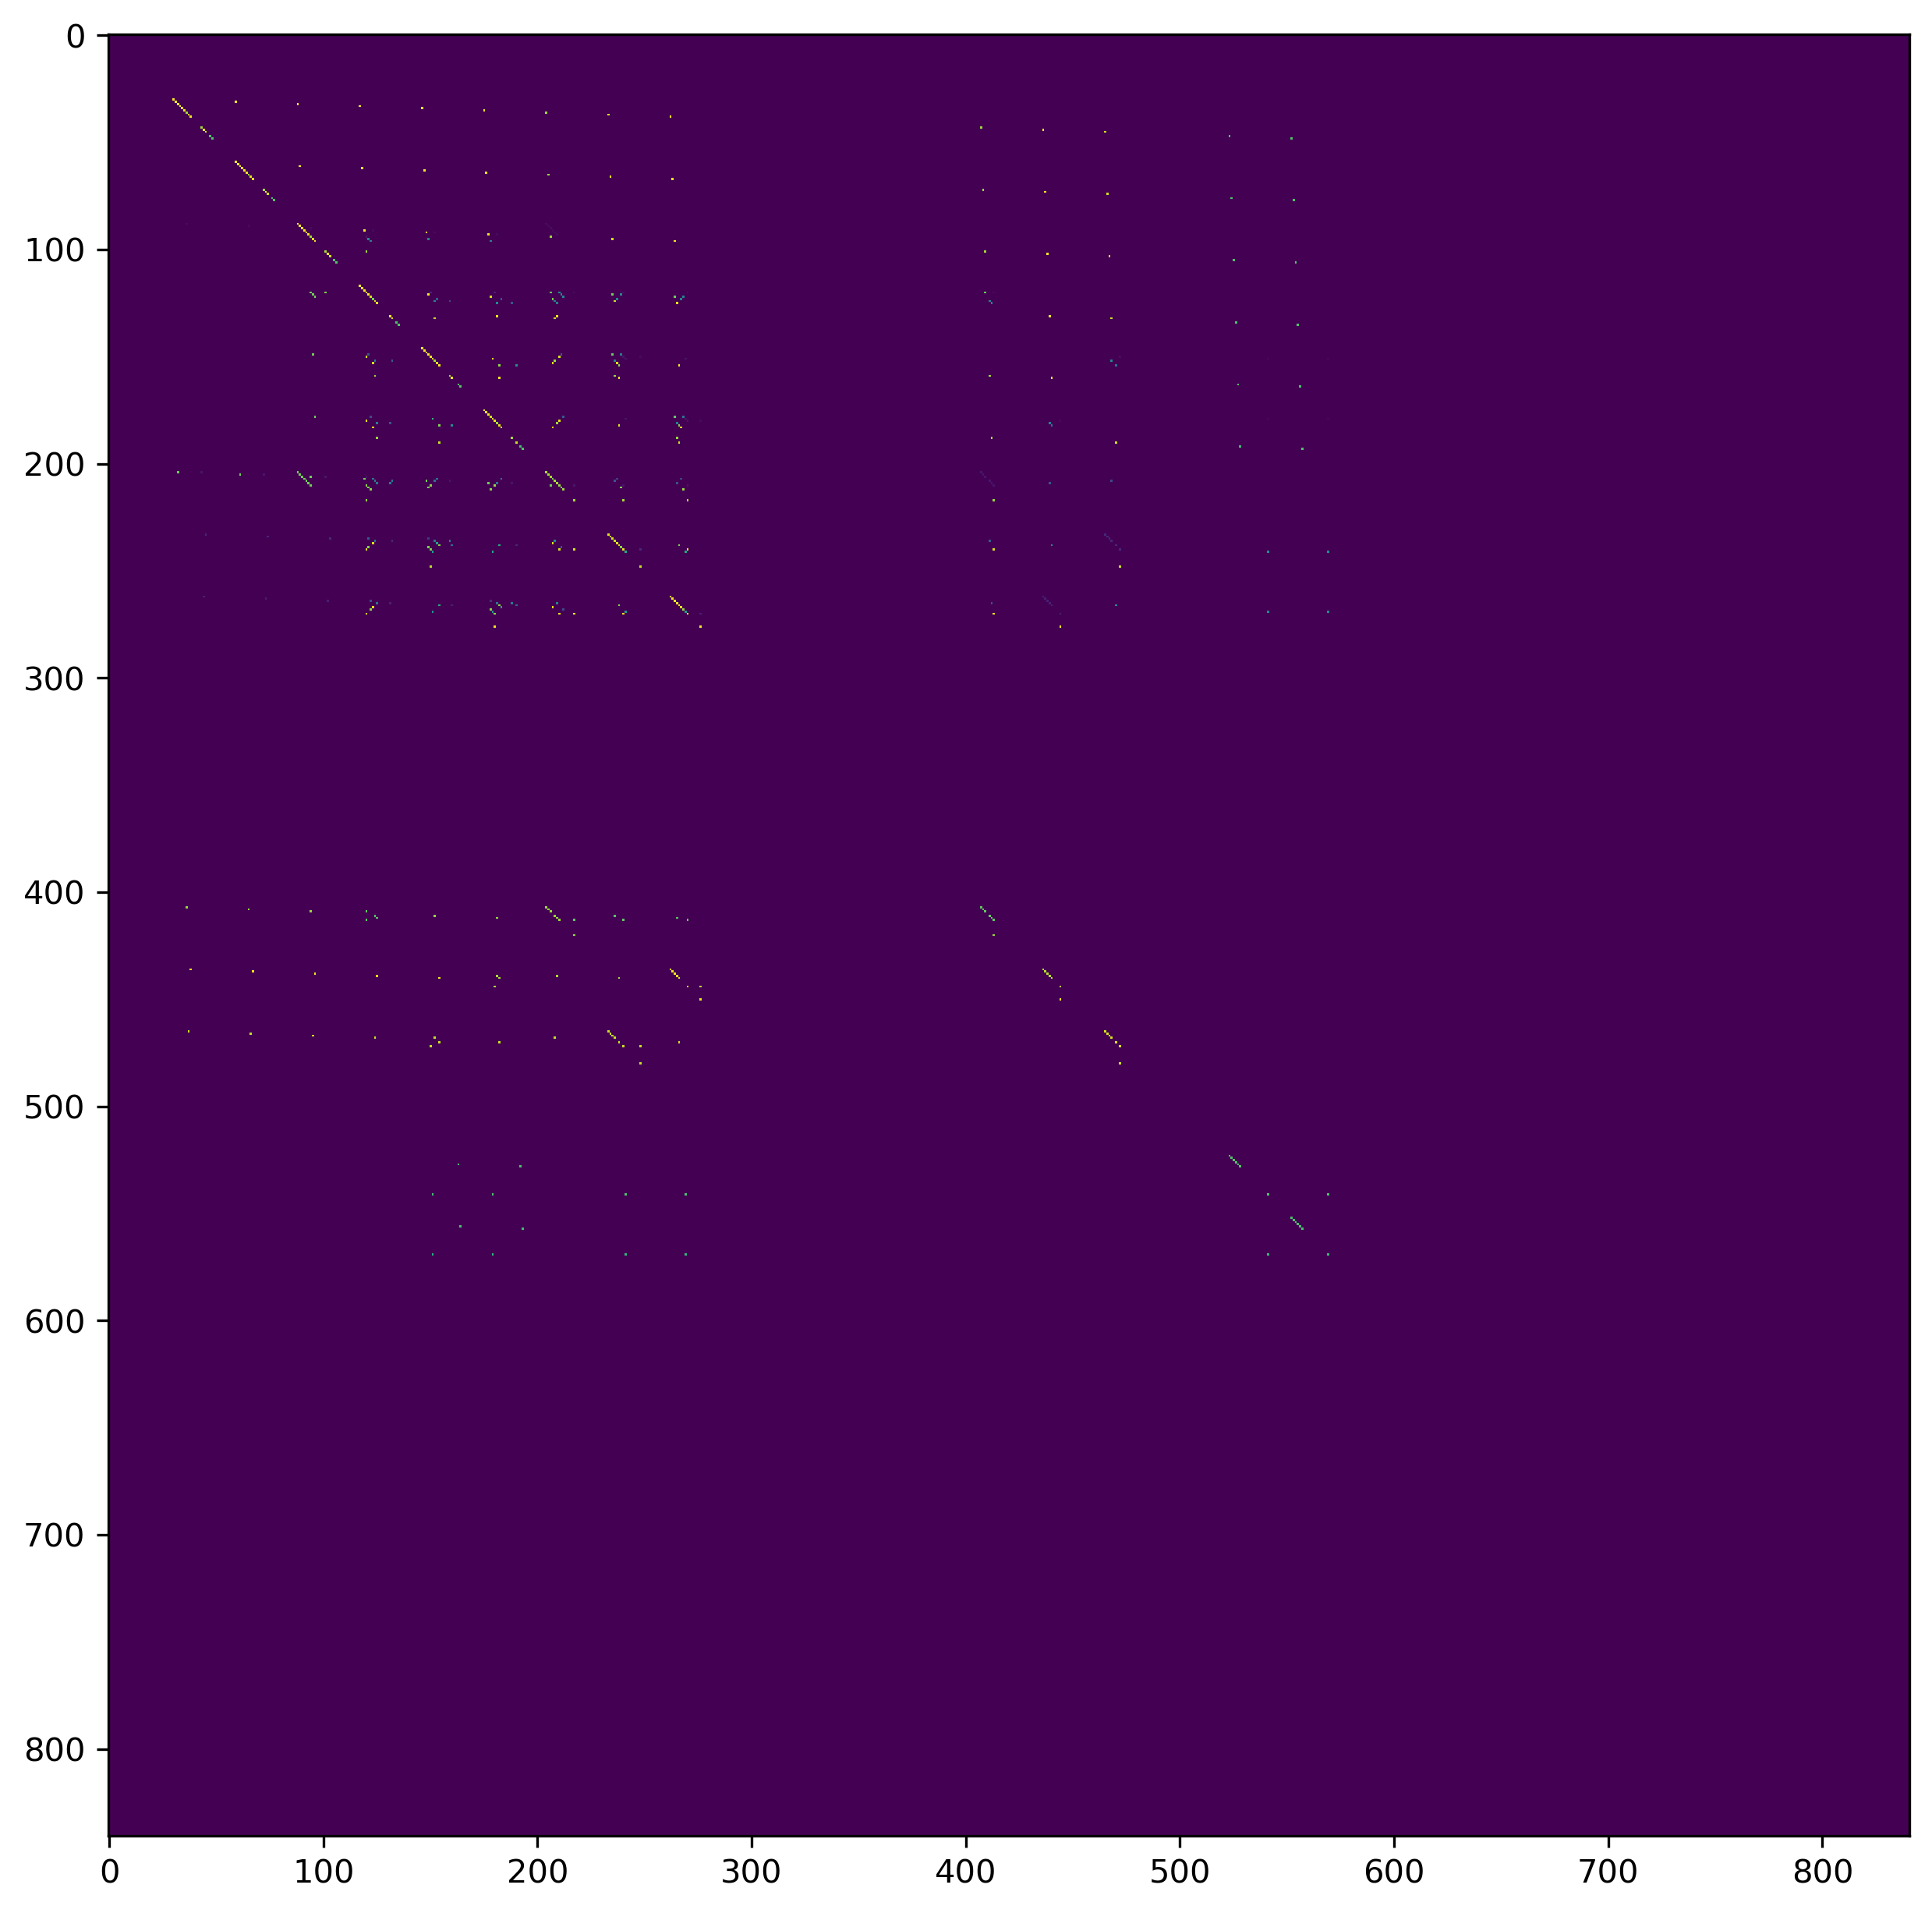

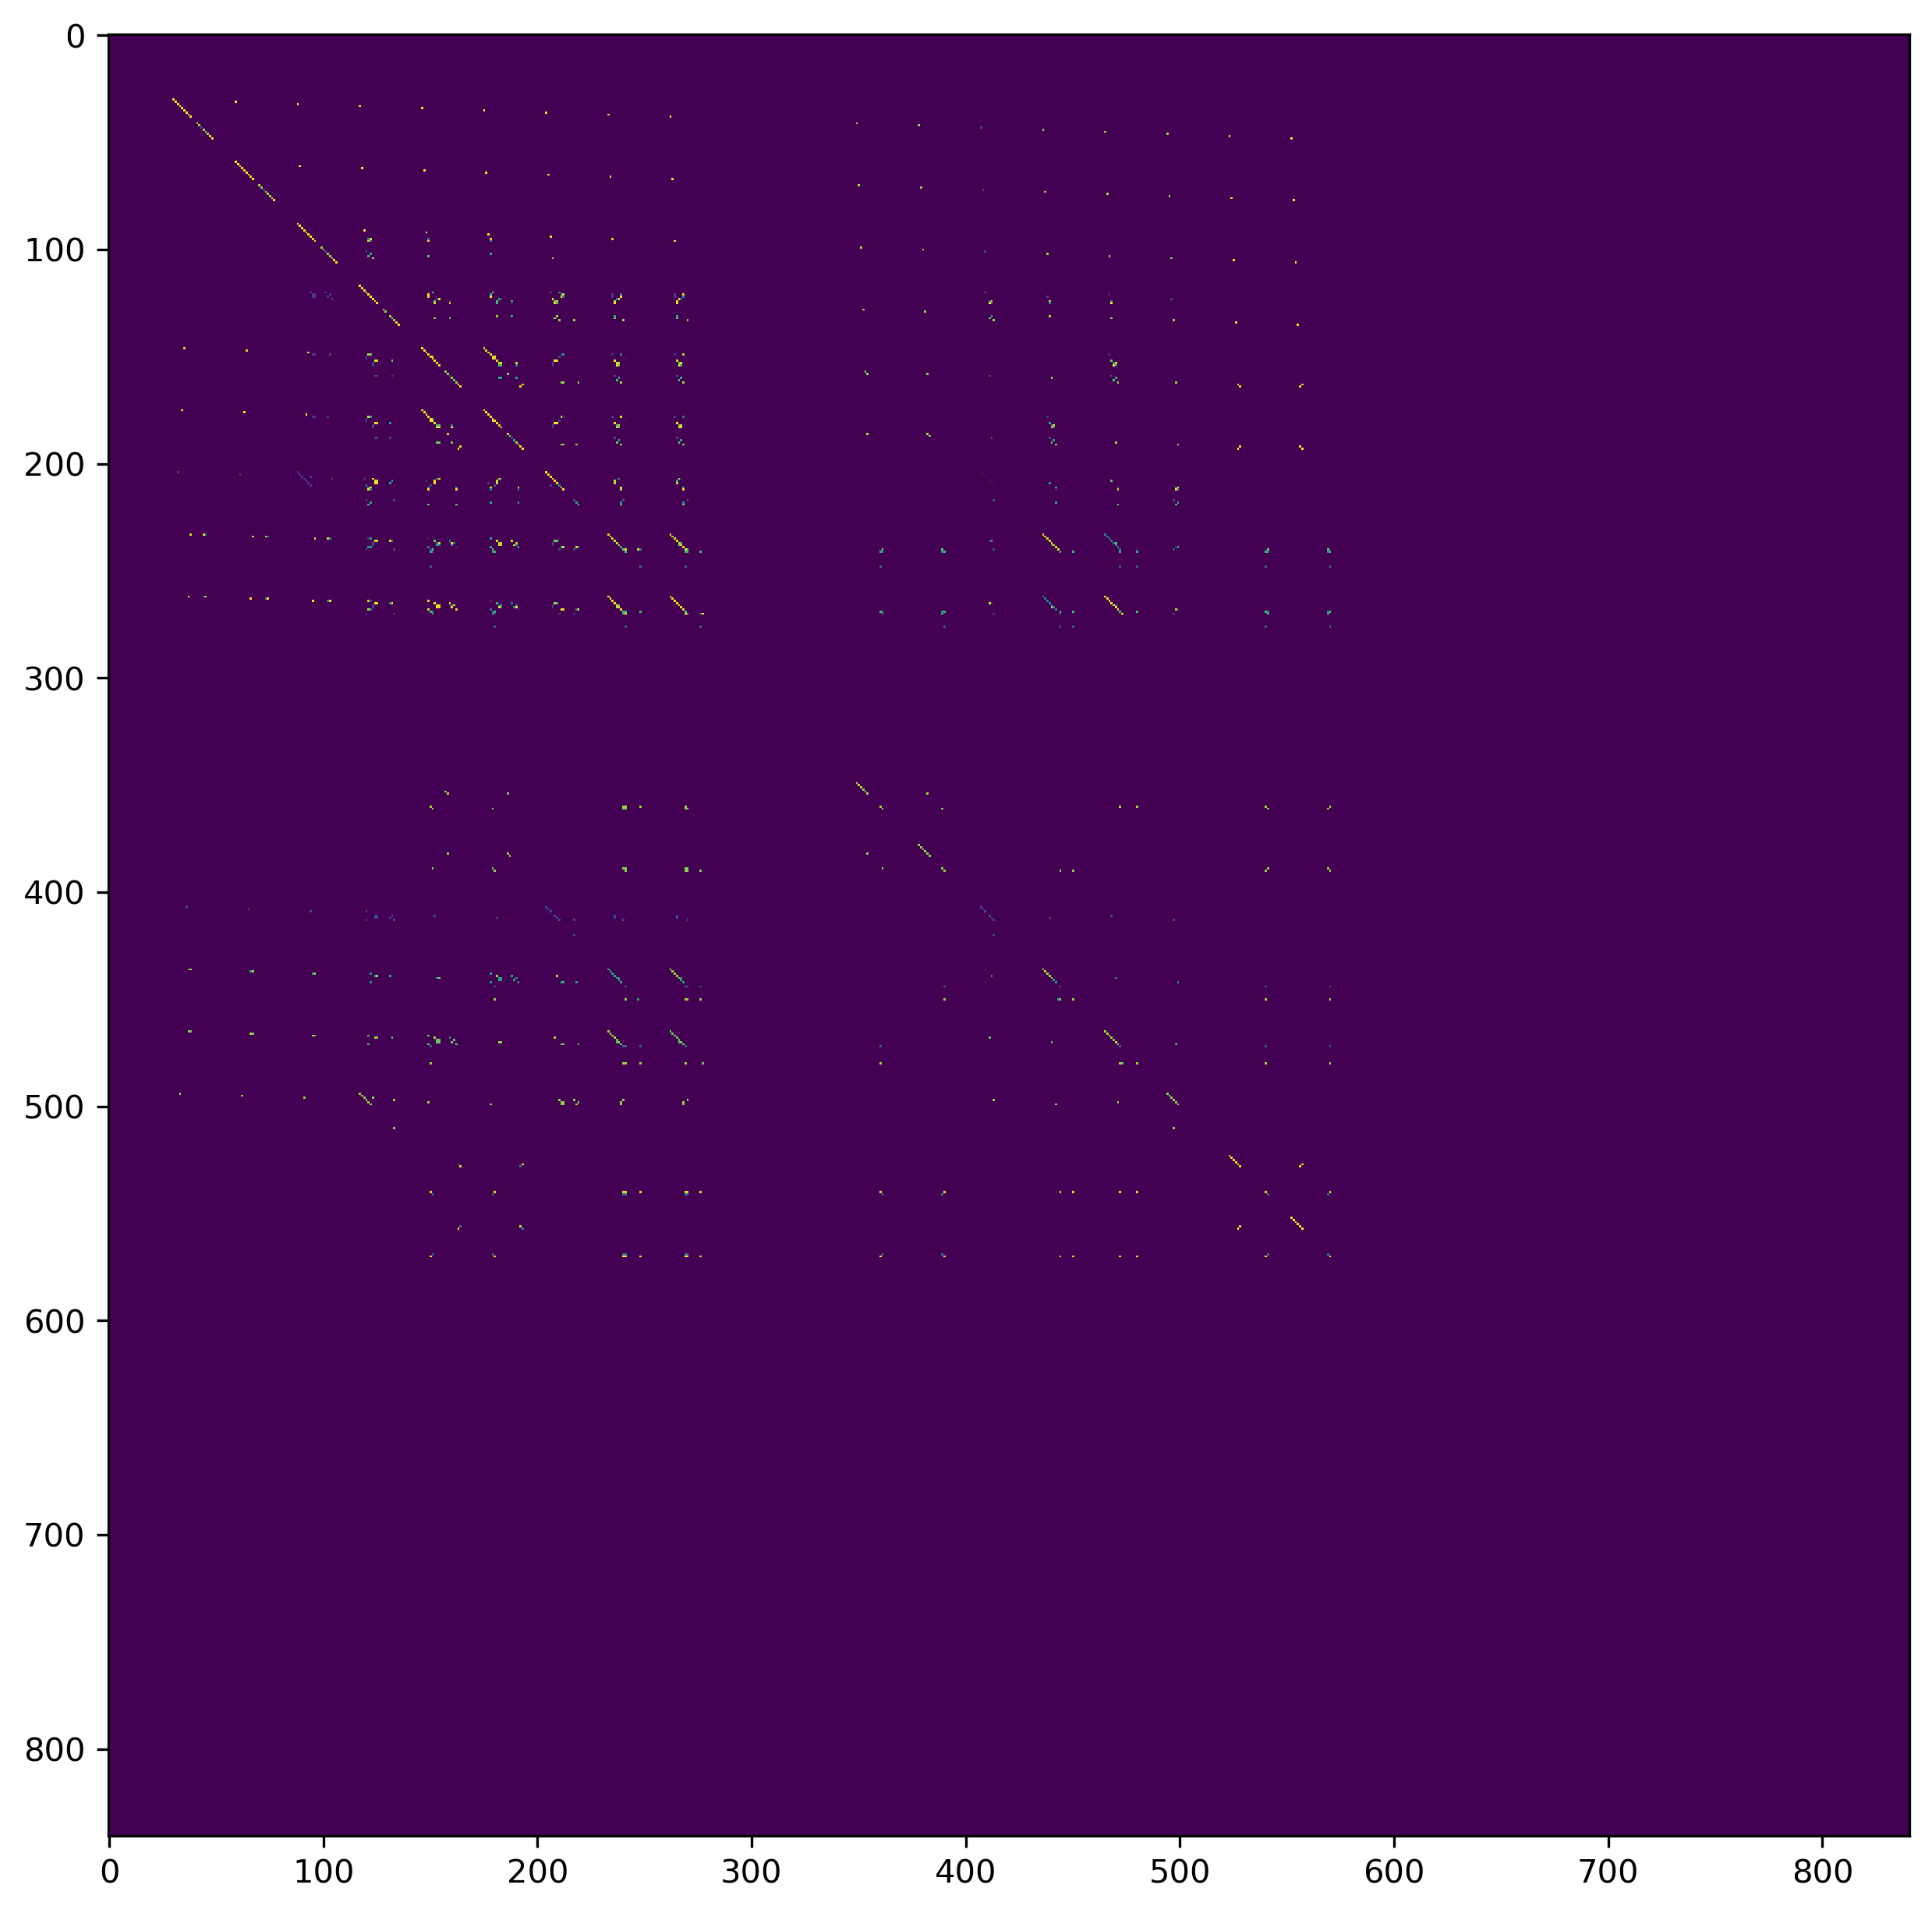

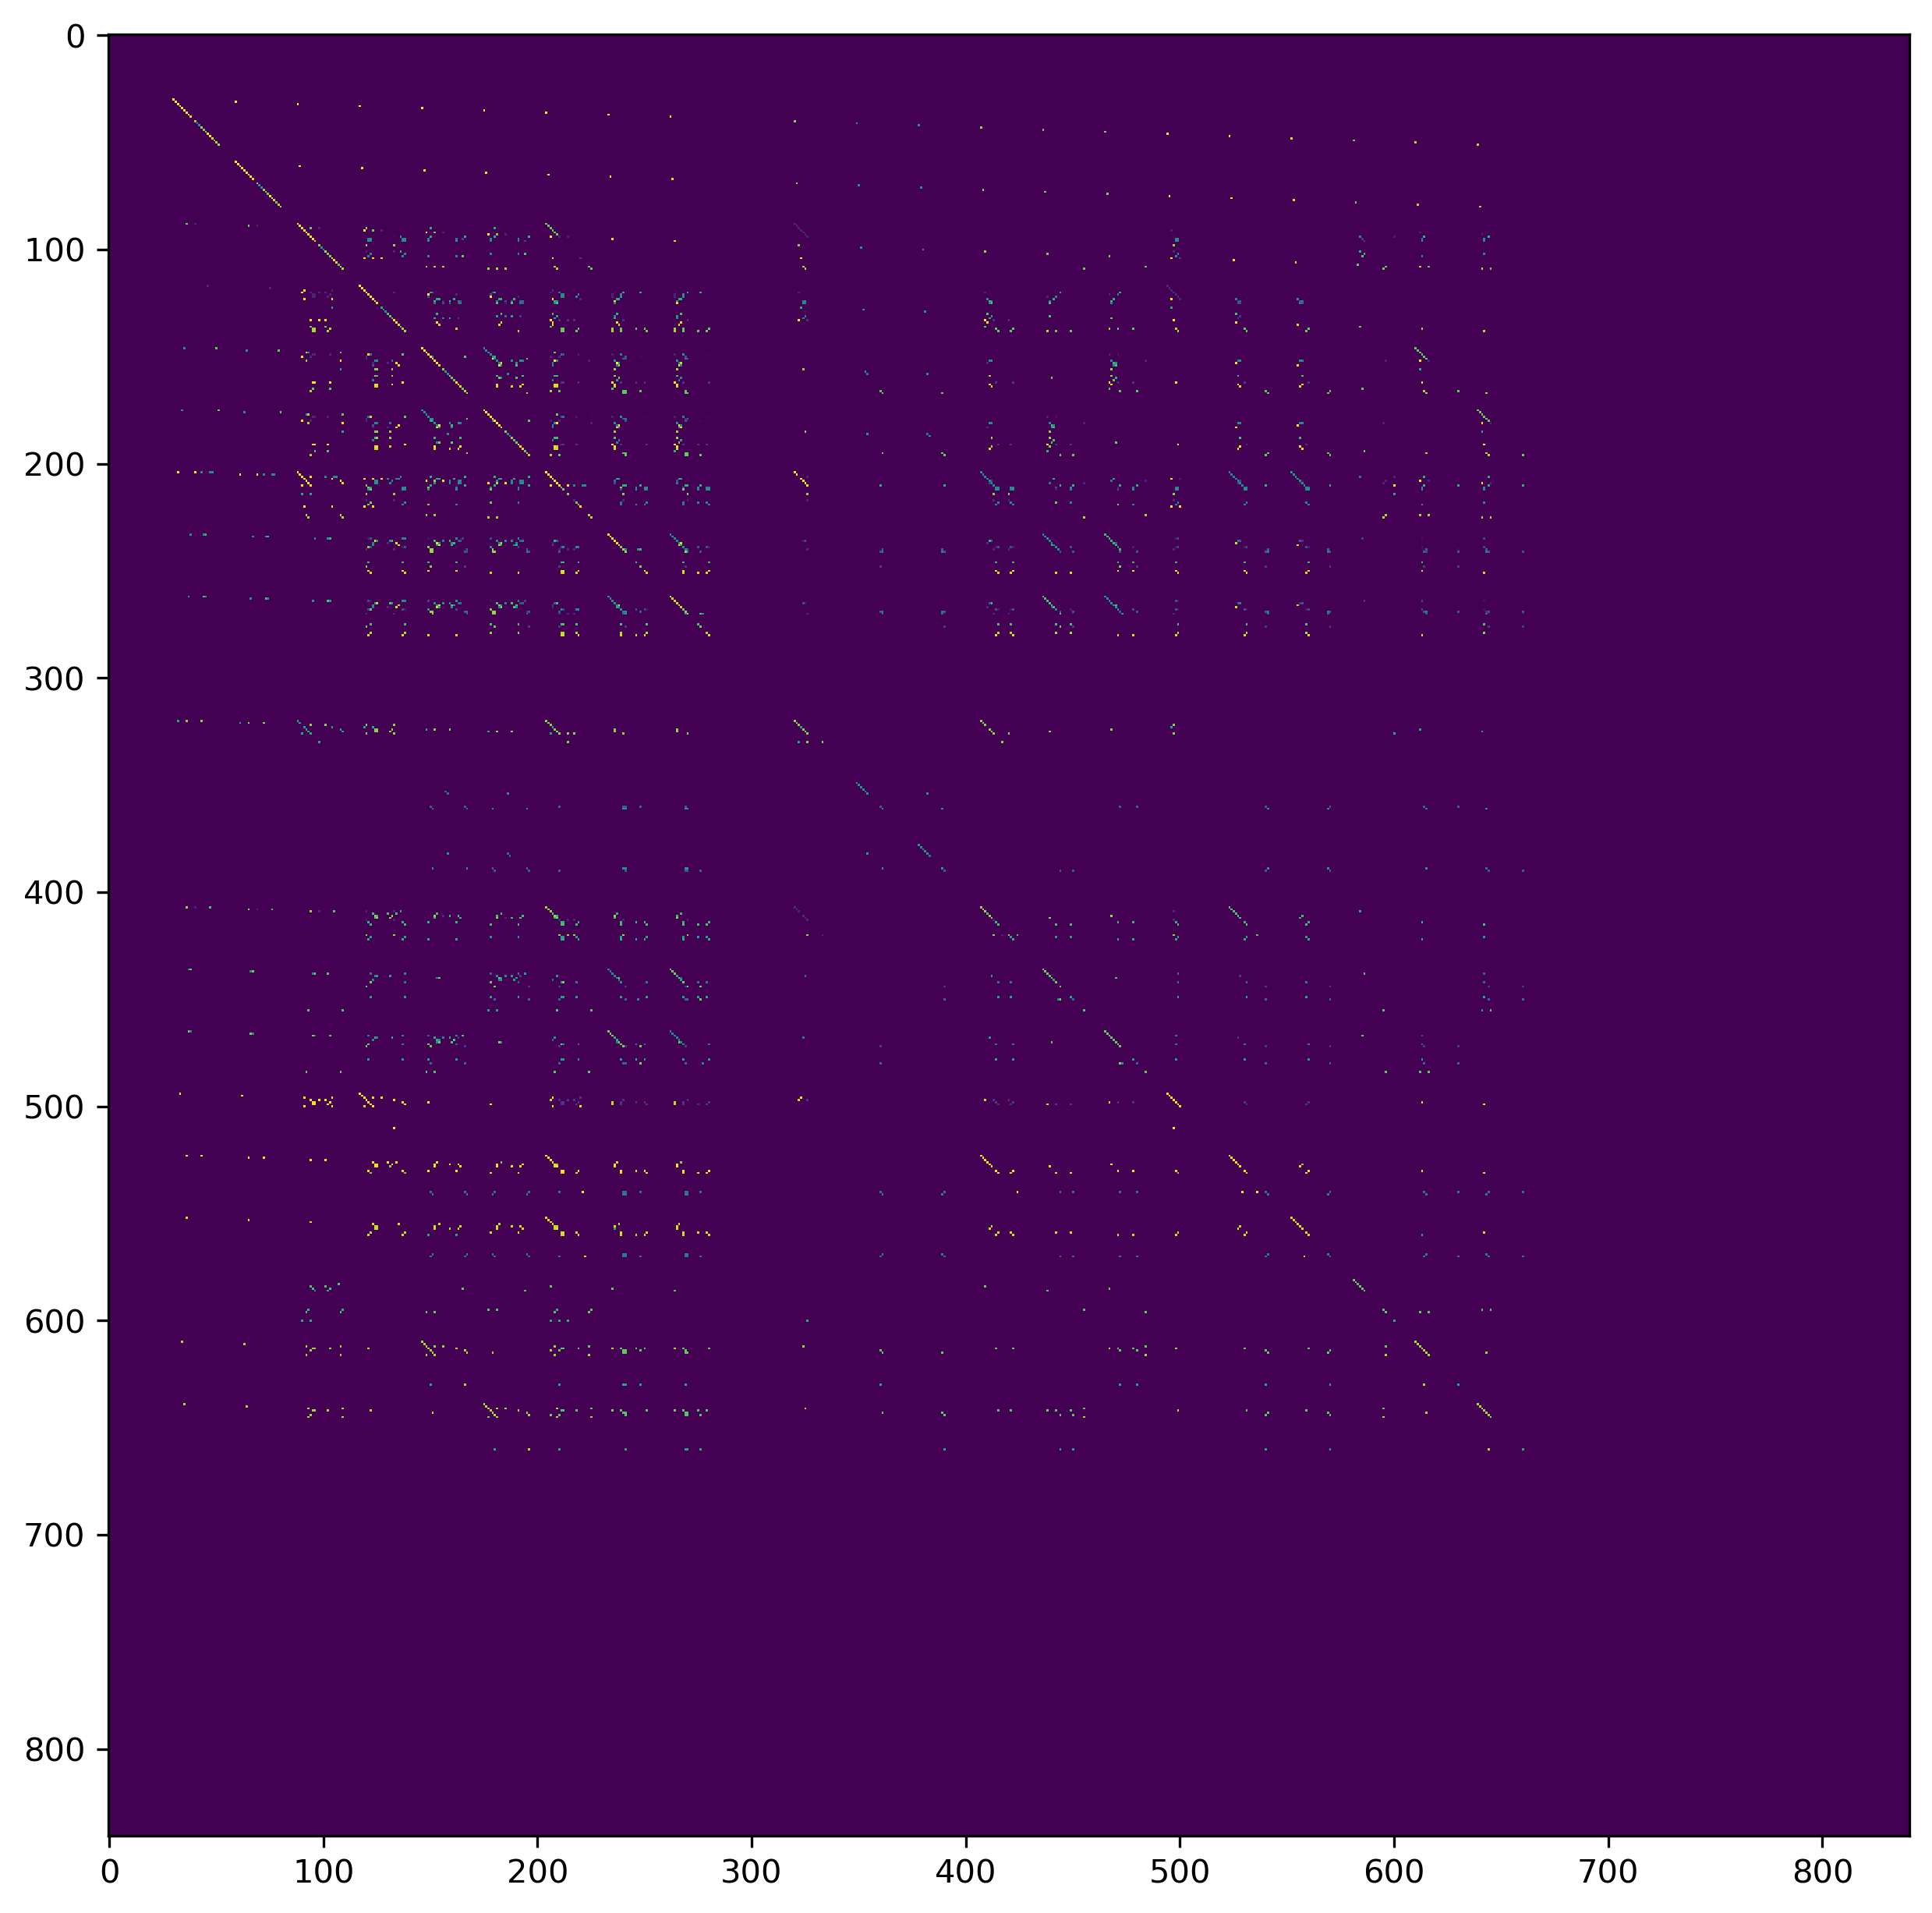

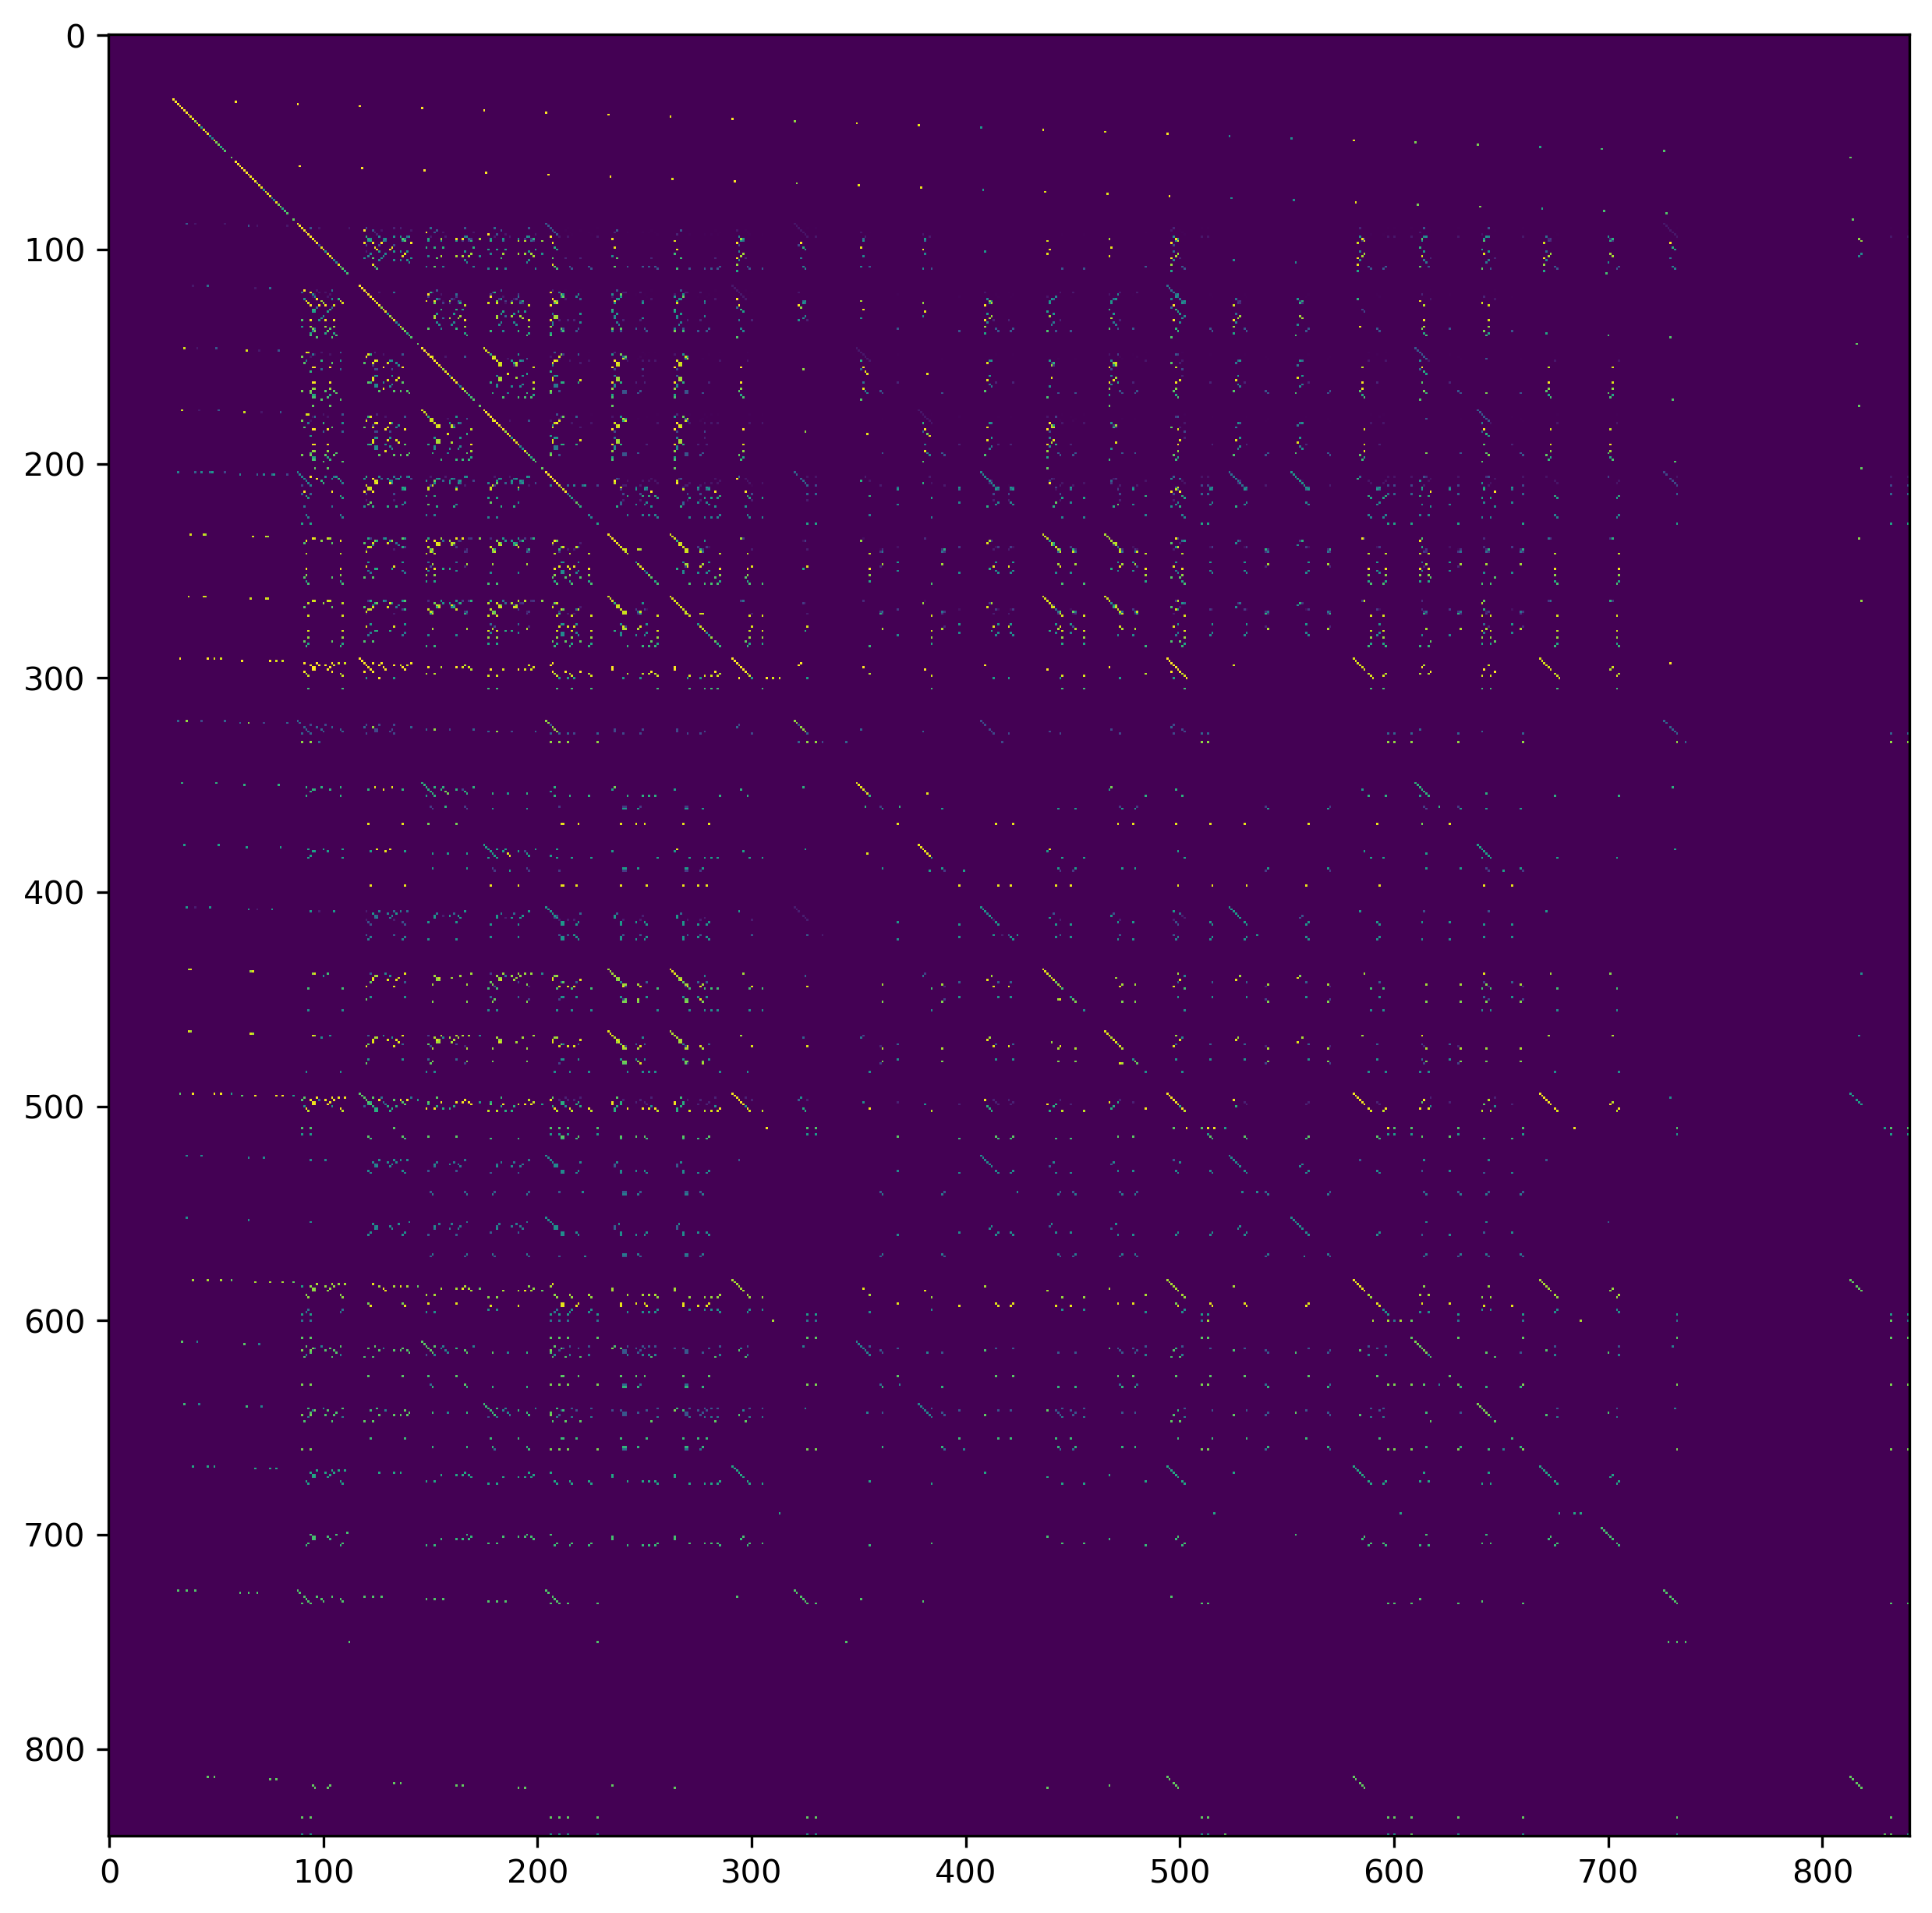

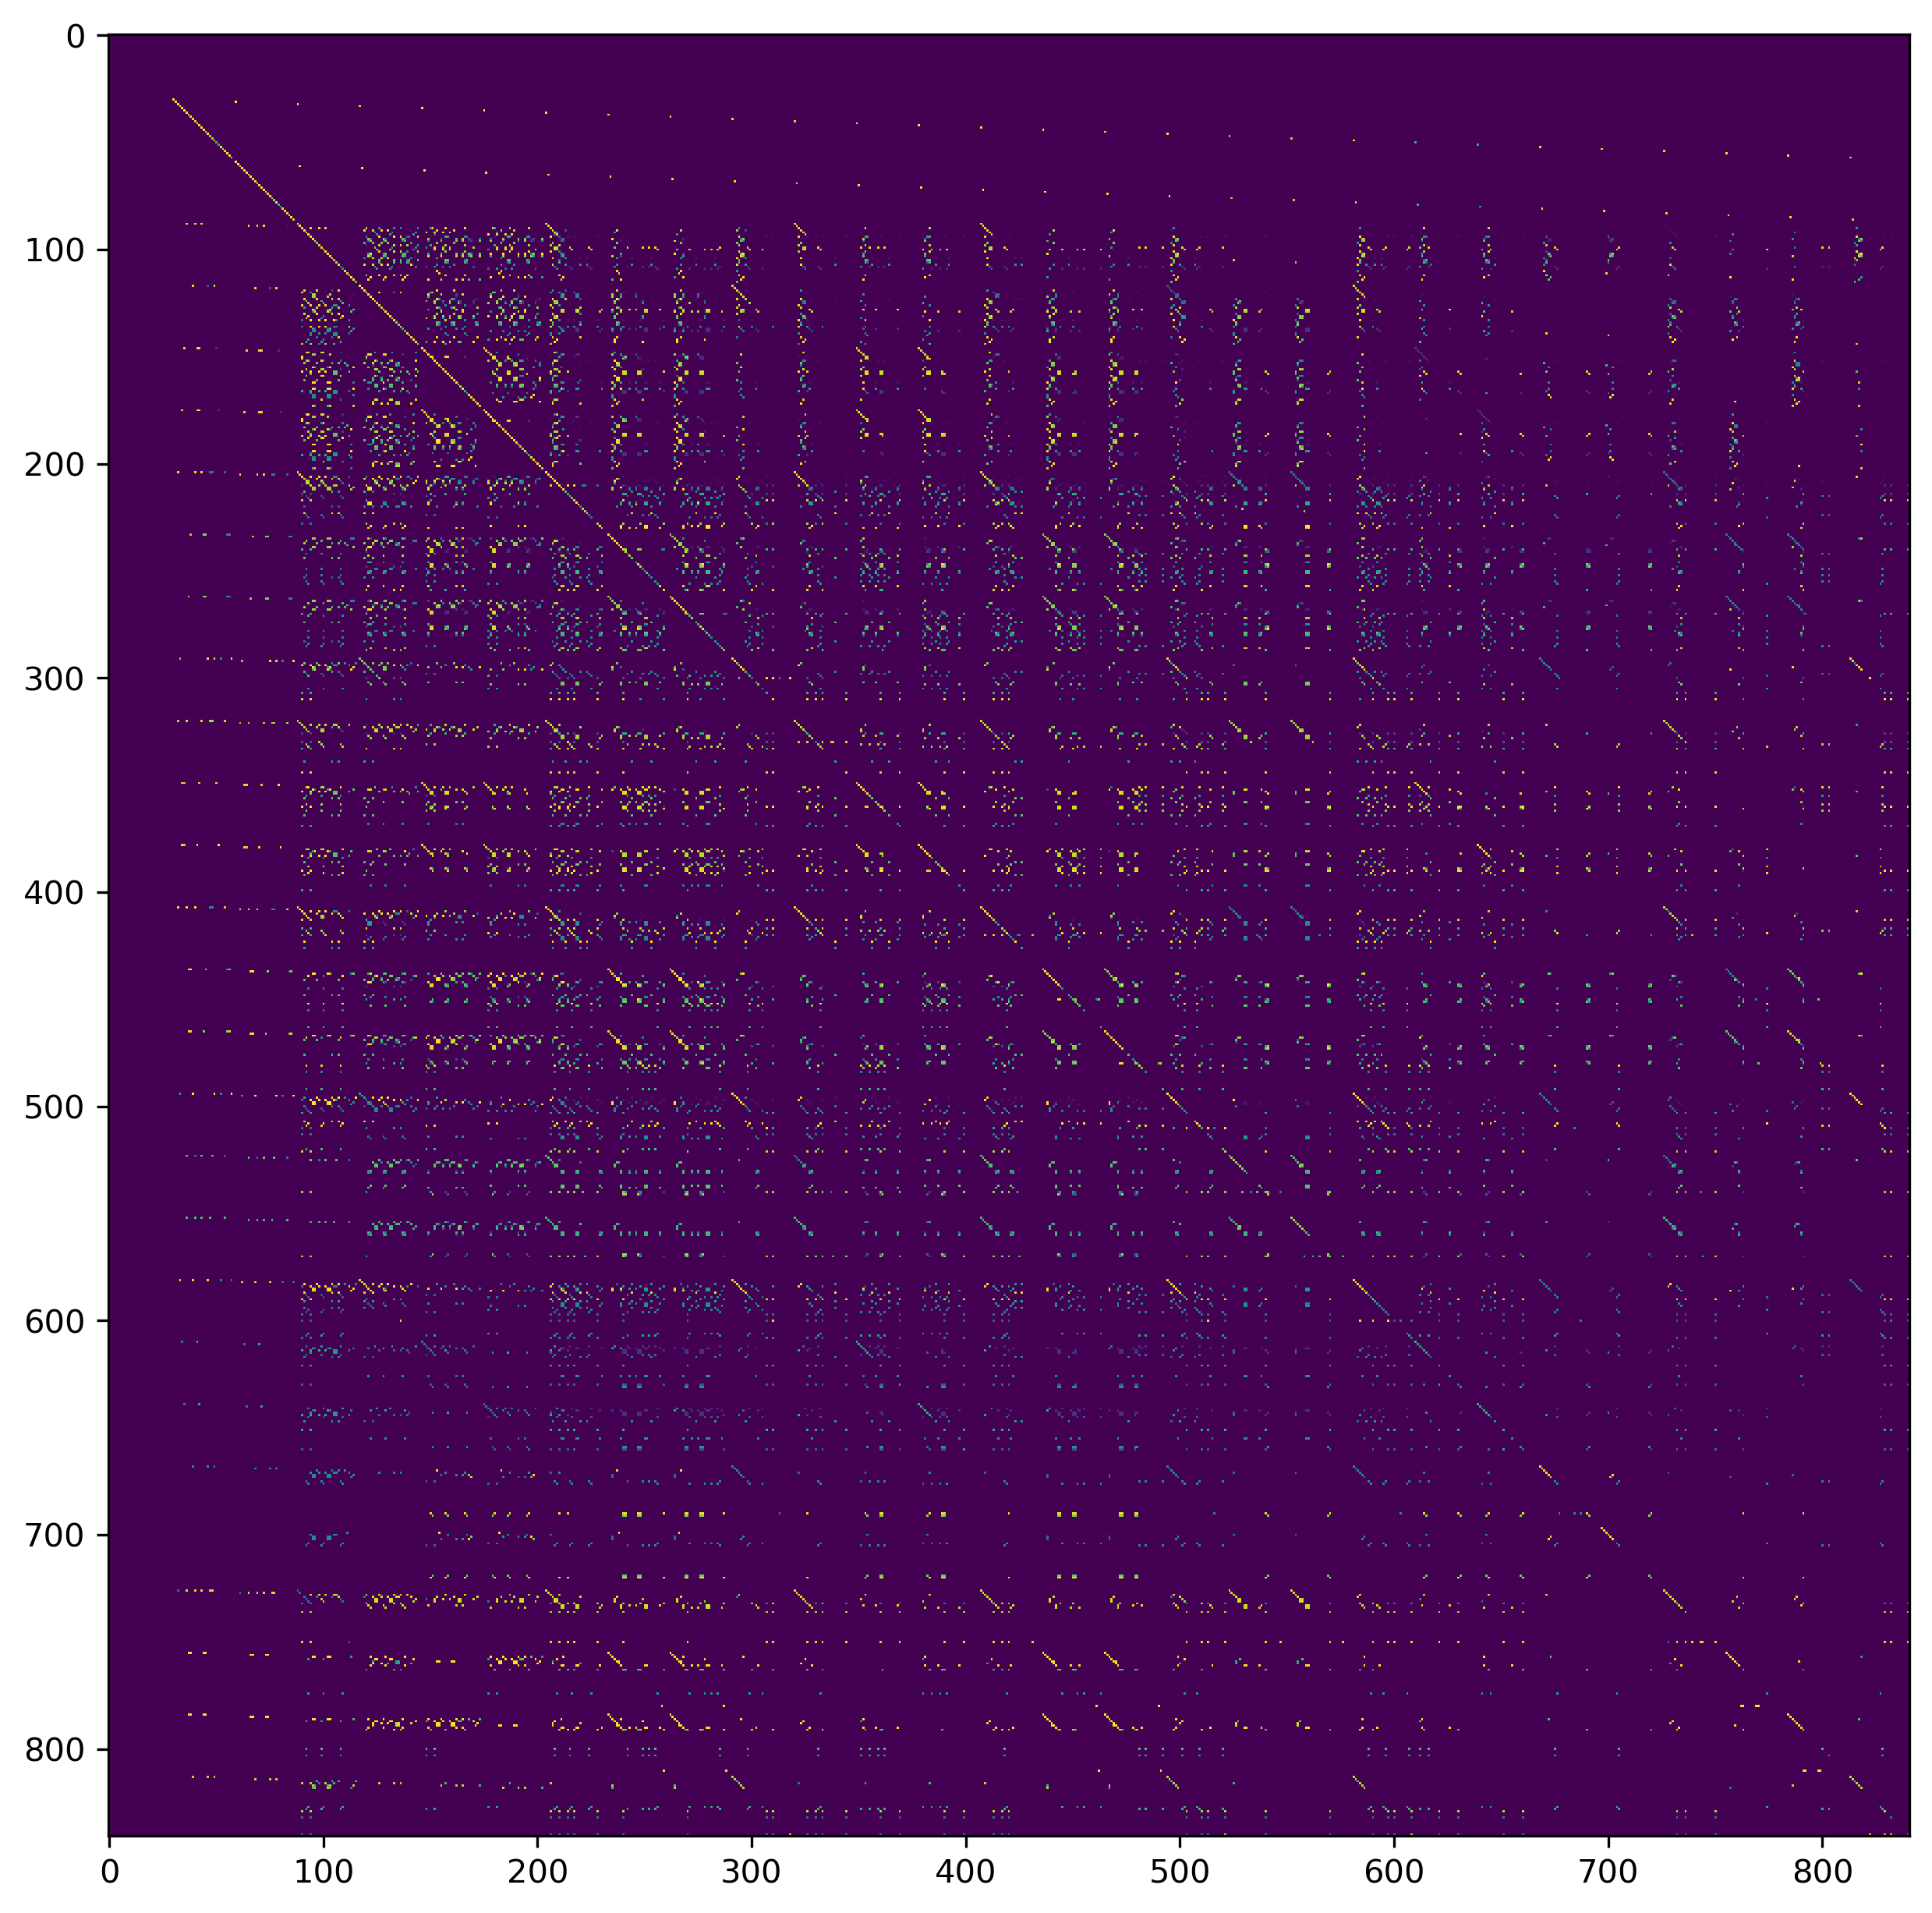

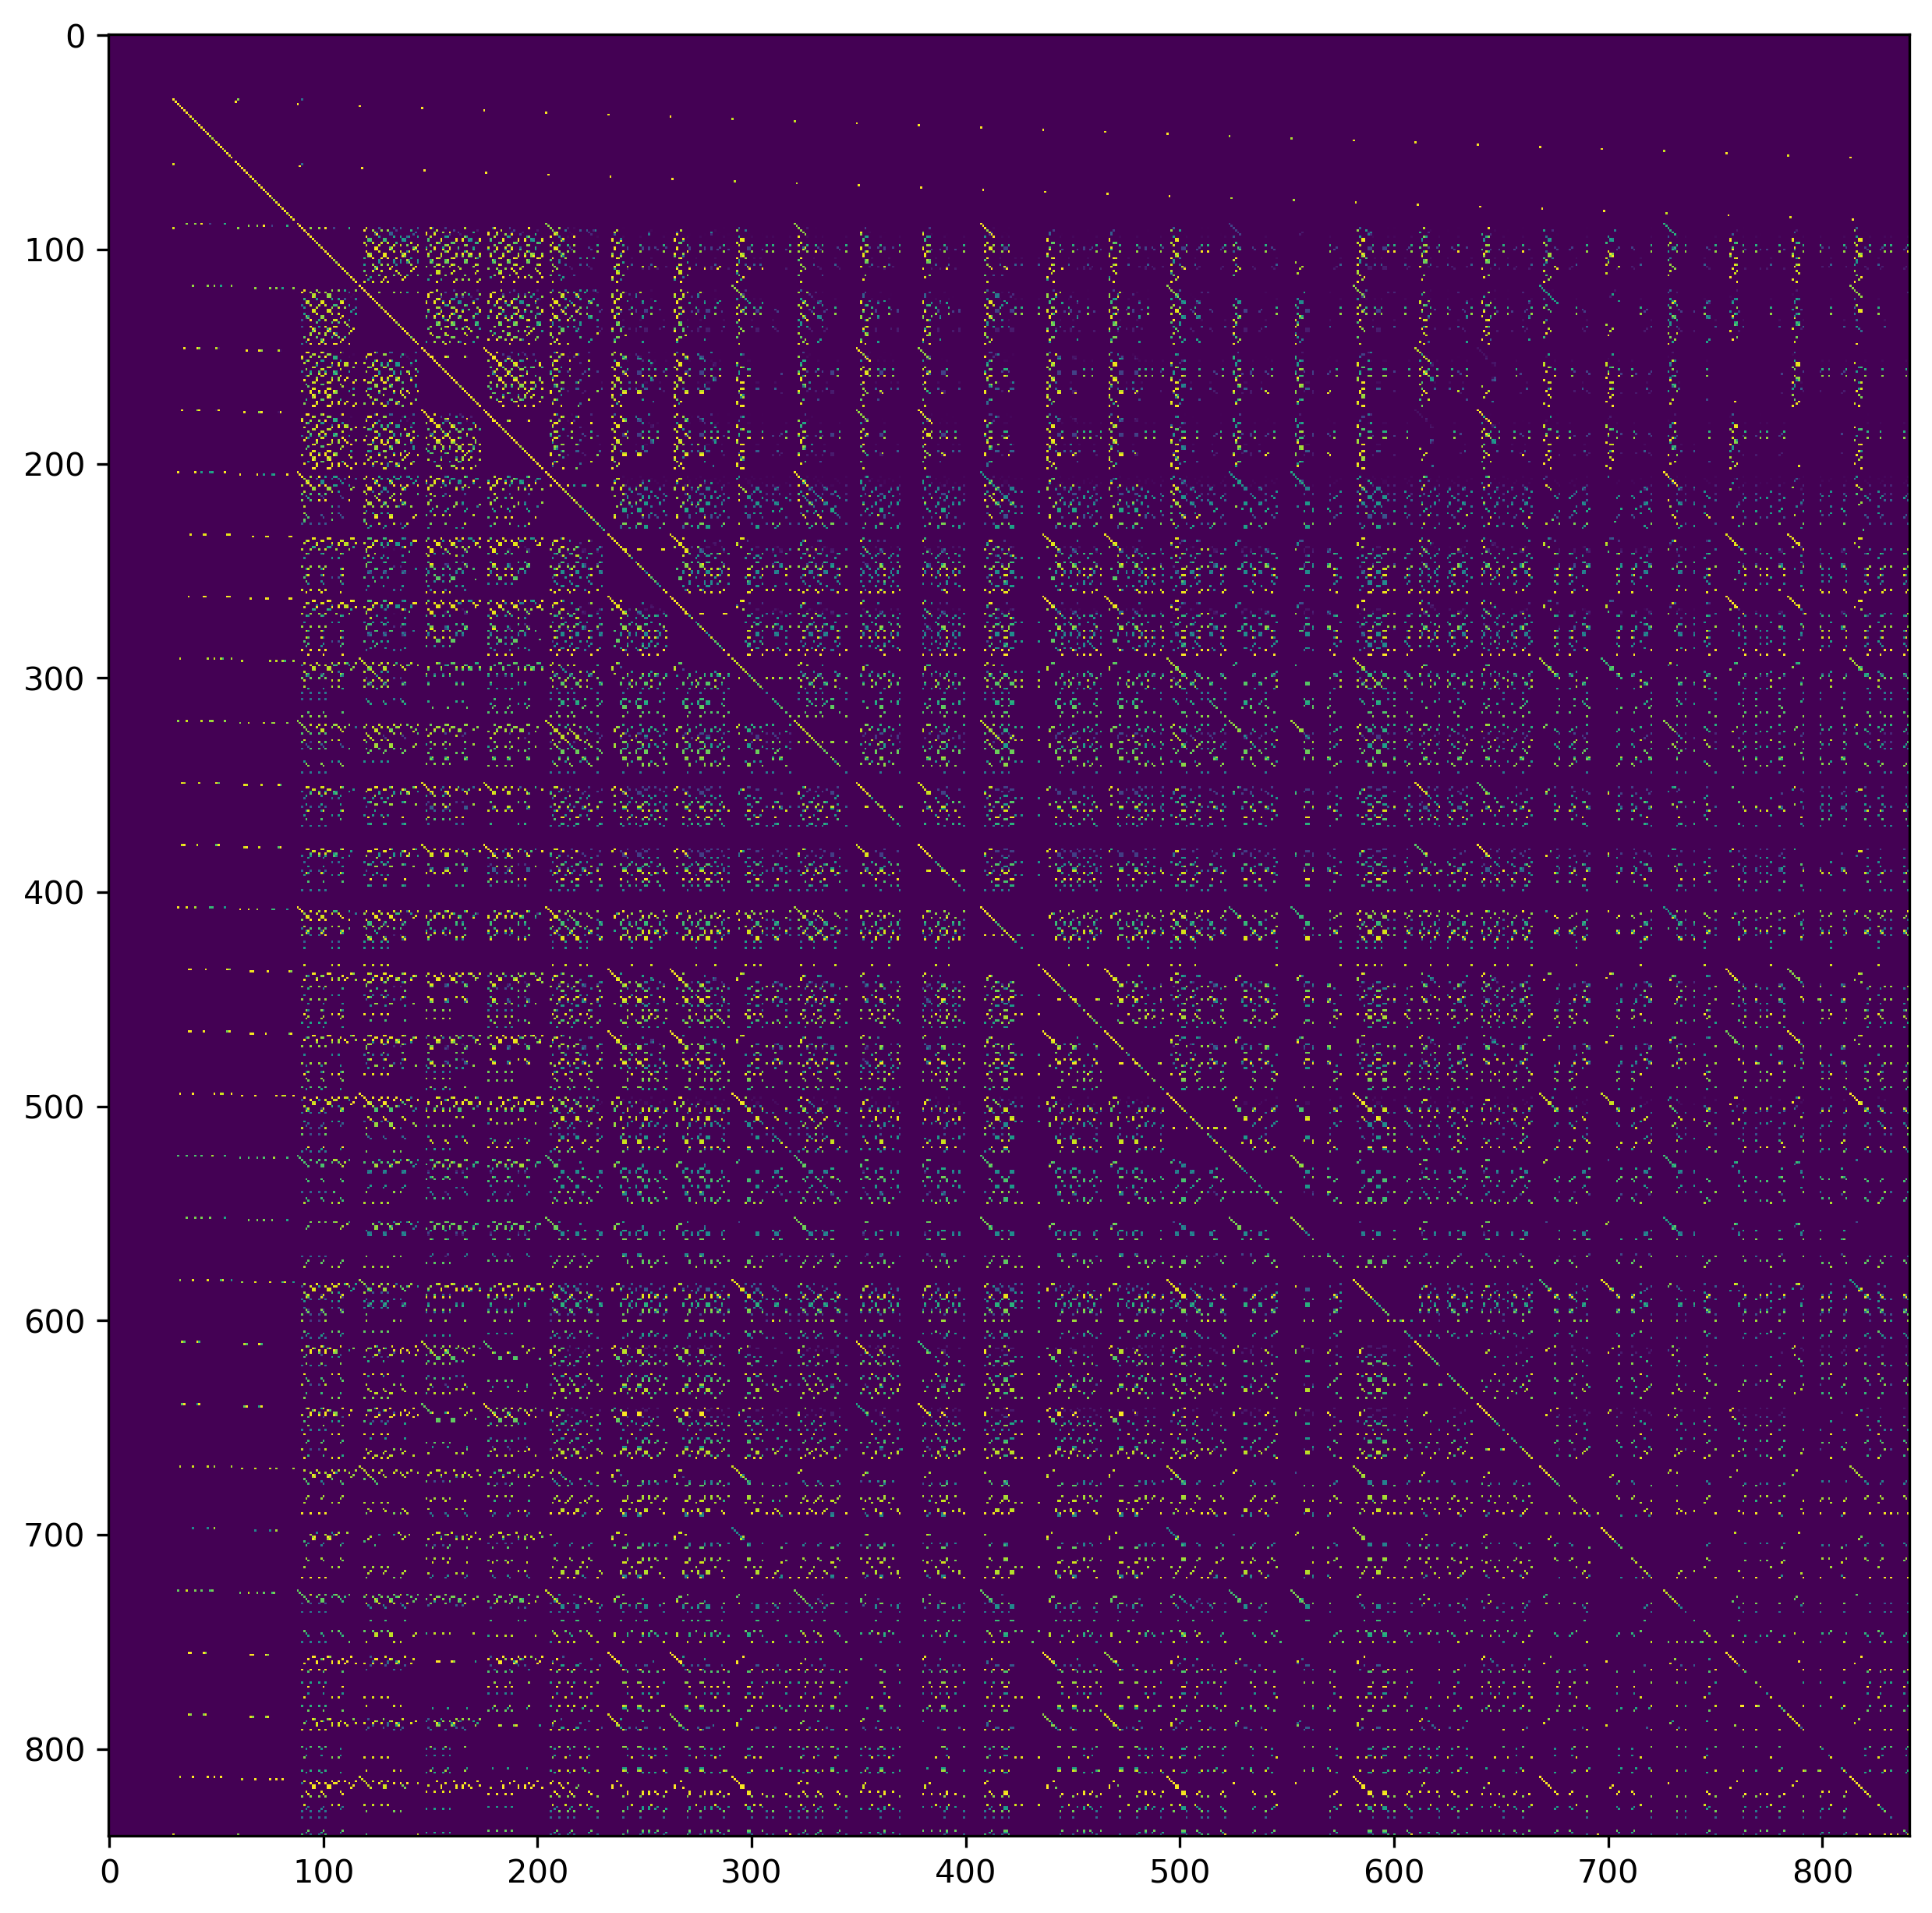

In [24]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 300
for m in maps:
    plt.imshow(m, cmap='viridis')
    plt.show()